# Bibliotecas

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np
import pickle

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (RobustScaler, 
                                   OneHotEncoder, 
                                   FunctionTransformer, 
                                   MultiLabelBinarizer)

# Estatística
from scipy.stats import chi2_contingency

# Machine Learning: Modelos
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Machine Learning: Avaliação
from sklearn import model_selection as ms
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurações gerais
import warnings
warnings.filterwarnings("ignore")


# Funções

In [2]:
#from IPython.display import HTML
def jupyter_settings():
    %matplotlib inline
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 9]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container{width: 100% !important;}</style>'))
    
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    # Aumenta a quantidade de texto mostrado nas células de saída
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'
jupyter_settings()

def dados_faltantes(df):
    faltantes_qtde = df.isna().sum()
    faltantes_perc = df.isna().mean() * 100
    faltantes_df = pd.DataFrame({'Qtde Faltantes': faltantes_qtde,
                                 'Perc Faltantes (%)': faltantes_perc}).sort_values(by = 'Perc Faltantes (%)', ascending = False)
    return faltantes_df.round(2)
    
def linhas_duplicadas(df):
    return (df.groupby(df.columns.tolist(), dropna = False)
              .size()
              .to_frame('qtde_linhas_duplicadas')
              .query('qtde_linhas_duplicadas > 1')
              .sort_values('qtde_linhas_duplicadas', ascending = False))

def converter_tipo(dataframe: pd.DataFrame, nome_coluna: str or list, tipo: str, formato_data: str = None) -> bool:     
    try:
        # Verifica se é uma lista ou uma string única
        colunas = [nome_coluna] if isinstance(nome_coluna, str) else nome_coluna
        
        for col in colunas:
            if col not in dataframe.columns:
                print(f"Erro: Coluna '{col}' não encontrada")
                return False
                
            if tipo == 'int':
                dataframe[col] = dataframe[col].astype(int)
            elif tipo == 'float':
                dataframe[col] = dataframe[col].astype(float)
            elif tipo == 'data':
                if formato_data:
                    dataframe[col] = pd.to_datetime(dataframe[col], format = formato_data)
                else:
                    dataframe[col] = pd.to_datetime(dataframe[col])
            elif tipo == 'str':
                dataframe[col] = dataframe[col].astype(str)
            else:
                print(f"Erro: Tipo '{tipo}' não reconhecido para a coluna '{col}'.")
                return False
        
        return True
    
    except Exception as e:
        print(f"Erro na conversão: {str(e)}")
        return False
        
    except Exception as e:
        print(f"Erro ao converter {nome_coluna} para {tipo}: {str(e)}")
        return False

def descricao_estatistica_variaveis(df, tipo = 'num'):
    if tipo == 'num':        
        variaveis_numericas = df.select_dtypes(include = ['number']) # Seleção de variáveis numéricas
        if variaveis_numericas.empty:
            return 'Não há variáveis numéricas no DataFrame.'        
        metricas = pd.DataFrame({'min': variaveis_numericas.min(),
                                 'max': variaveis_numericas.max(),
                                 'amplitude': variaveis_numericas.max() - variaveis_numericas.min(),
                                 'mean': variaveis_numericas.mean(),
                                 'median': variaveis_numericas.median(),
                                 'std': variaveis_numericas.std(),
                                 'assimetria': variaveis_numericas.skew(),
                                 'kurtosis': variaveis_numericas.kurtosis()})
        return metricas.T    
    elif tipo == 'cat': # Seleção de variáveis categóricas        
        variaveis_categoricas = df.select_dtypes(include = ['object', 'category'])
        if variaveis_categoricas.empty:
            return 'Não há variáveis categóricas no DataFrame.'
        metricas_categoricas = pd.DataFrame({'coluna': variaveis_categoricas.columns,
                                             'valores_unicos': [variaveis_categoricas[col].nunique() for col in variaveis_categoricas.columns]})
        return metricas_categoricas
    else:
        return "O parâmetro 'tipo' deve ser 'num' ou 'cat'."
    
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def analise_variancia(df):
    numericas = df.select_dtypes(include = ['number'])
    categoricas = df.select_dtypes(include = ['object', 'category'])
    
    if not numericas.empty:
        print('Variância das variáveis numéricas:')
        variancias = numericas.var()
        variancias_sorted = variancias.sort_values(ascending = False)
        
        with pd.option_context('display.float_format', '{:f}'.format):
            print(variancias_sorted.to_string(float_format=lambda x: f"{x:,.0f}" if x >= 1 else f"{x:.8f}"))
    
    if not categoricas.empty:
        print('\nNúmero de valores únicos nas variáveis categóricas:')
        print(categoricas.nunique())

def ml_error(y, y_pred, desvpad = True):
    mae = mean_absolute_error(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    std_mae = np.std(np.abs(y - y_pred))
    std_mape = np.std(np.abs((y - y_pred) / y))
    std_rmse = np.std(np.sqrt(y - y_pred))
    
    # Substituir NaN por 0
    std_mae = 0 if np.isnan(std_mae) else std_mae
    std_mape = 0 if np.isnan(std_mape) else std_mape
    std_rmse = 0 if np.isnan(std_rmse) else std_rmse
    
    if desvpad:
        return pd.DataFrame({'mae': f"{mae:.2f} +/- {std_mae:.2f}",
                             'mape': f"{mape:.2f}% +/- {std_mape:.2f}%",
                             'rmse': f"{rmse:.2f} +/- {std_rmse:.2f}",
                             'r2': f"{r2:.2f}"}, index = [0])
    else:
        return pd.DataFrame({'mae': f"{mae:.2f}",
                             'mape': f"{mape:.2f}%",
                             'rmse': f"{rmse:.2f}",
                             'r2': f"{r2:.2f}"}, index = [0])

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados
##### O objetivo deste passo é ter um entendimento inicial de como os dados estão relacionados com o problema de negócio proposto.

### 1.1 Descrição do desafio

* Você foi alocado em um time da Indicium contratado por um estúdio de Hollywood chamado PProductions, e agora deve fazer uma análise em cima de um banco de dados cinematográfico para orientar qual tipo de filme deve ser o próximo a ser desenvolvido. Lembre-se que há muito dinheiro envolvido, então a análise deve ser muito detalhada e levar em consideração o máximo de fatores possíveis (a introdução de dados externos é permitida - e encorajada).

### 1.2 Descrição das colunas (dicionário de dados)

**Series_Title** – Nome do filme

**Released_Year** - Ano de lançamento

**Certificate** - Classificação etária

**Runtime** – Tempo de duração

**Genre** - Gênero

<span style = "color:green">**IMDB_Rating**</span> - Nota do IMDB

**Overview** - Overview do filme

**Meta_score** - Média ponderada de todas as críticas 

**Director** – Diretor

**Star1** - Ator/atriz #1

**Star2** - Ator/atriz #2

**Star4** - Ator/atriz #4

**Star3** - Ator/atriz #3

**No_of_Votes** - Número de votos

**Gross** - Faturamento

### 1.2.1 Interpretação da coluna Certificate (faixa etária)

<span style = "color:green">Sistema Americano (MPAA - Motion Picture Association)</span>

G - General Audiences: Todas as idades admitidas

PG - Parental Guidance Suggested: Algum material pode não ser adequado para crianças

PG-13 - Parents Strongly Cautioned: Algum material pode ser inadequado para menores de 13 anos

R - Restricted: Menores de 17 anos requerem acompanhante adulto

NC-17 - Adults Only: Apenas adultos (não aparece na sua lista)

fonte: https://www.motionpictures.org/film-ratings/

<span style = "color:green">Sistema Indiano (CBFC - Central Board of Film Certification)</span>
    
U - Unrestricted Public Exhibition: Para todas as idades

UA - Unrestricted Public Exhibition with caution: Para todas as idades, mas com aviso parental

A - Adults Only: Apenas para adultos (18+)

fonte: https://www.cbfcindia.gov.in/cbfcAdmin/

<span style = "color:green">Sistema Britânico (BBFC - antigo)</span>
 
U - Universal: Para todas as idades

A - Adult: Para adultos (histórico, não usado mais)

U/A - Provavelmente variação do sistema indiano

fonte: https://www.bbfc.co.uk/

<span style = "color:green">Classificação de TV</span>

TV-PG - Parental Guidance Suggested: Programa de TV com orientação parental

fonte: https://www.tvguidelines.org/

<span style = "color:green">Classificações Históricas (Antigas)</span>
 
Passed - Sistema antigo dos EUA (pré-1968): Filme aprovado sem restrições específicas

Approved - Similar a "Passed", indica aprovação para exibição

GP - General Public: Antiga classificação similar à PG (1970-1972)

fonte: https://www.filmsite.org/rating.html

### 1.3 Carregar os dados

In [3]:
df = pd.read_csv('../dataset/desafio_indicium_imdb.csv', index_col = 0)

### 1.3.1 Copia dos dados

In [4]:
df1 = df.copy()

### 1.3.2 Conhecer os dados

In [5]:
df1.head(3)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


### 1.4 Dimensão dos dados

In [6]:
print('Tamanho da tabela de dados:', df1.shape)

Tamanho da tabela de dados: (999, 15)


### 1.5 Verificar NA's

In [7]:
dados_faltantes(df1)

,Qtde Faltantes,Perc Faltantes (%)
Gross,169,16.92
Meta_score,157,15.72
Certificate,101,10.11
Runtime,0,0.00
Genre,0,0.00
Series_Title,0,0.00
Released_Year,0,0.00
Overview,0,0.00
IMDB_Rating,0,0.00
Star1,0,0.00


* Existem 3 colunas que apresentavam dados faltantes: 'Gross', 'Meta_score' e 'Certificate', como não tenho informações suficientes para compreender os motivos destes NAN, optei inicialmente por removê-las do dataset, mesmo por que a quantidade destes dados faltantes é baixa. Caso necessário em etapas posteriores, uma alternativa seria realizar a imputação desses valores por meio de algoritmos de regressão e classificação.

### 1.5.1 Tratar NA's

In [8]:
df1 = df1.dropna(subset = ['Gross', 'Meta_score', 'Certificate']).reset_index(drop = True)

In [9]:
dados_faltantes(df1)

,Qtde Faltantes,Perc Faltantes (%)
Series_Title,0,0.0
Released_Year,0,0.0
Certificate,0,0.0
Runtime,0,0.0
Genre,0,0.0
IMDB_Rating,0,0.0
Overview,0,0.0
Meta_score,0,0.0
Director,0,0.0
Star1,0,0.0


In [10]:
df1.shape

(713, 15)

### 1.6 Tipo de dados

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    object 
 2   Certificate    713 non-null    object 
 3   Runtime        713 non-null    object 
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 83.7+ KB


### 1.6.1 Editar os tipos de dados

In [12]:
df1.Released_Year.unique()

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2019',
       '2014', '1998', '1997', '1995', '1991', '1977', '1954', '2011',
       '2006', '2000', '1988', '1985', '1968', '1960', '1942', '1936',
       '1931', '2018', '2016', '2017', '2012', '2009', '1981', '1979',
       '1964', '2004', '1992', '1987', '1986', '1984', '1983', '1976',
       '1973', '1971', '1965', '1962', '1959', '1958', '1952', '1944',
       '1941', '2013', '2007', '2005', '1989', '1963', '1950', '1948',
       '2015', '1996', '1982', '1978', '1967', '1951', '1949', '1940',
       '1939', '1934', '1970', '1969', '1961', '1946', '1930', '1938',
       '1933', 'PG', '1953'], dtype=object)

* Existe uma linha na coluna 'Released_Year' que contém o um valor não numérico então optei por eliminar essa linha

In [13]:
df1 = df1[df1.Released_Year != "PG"]

In [14]:
# Released_Year 
converter_tipo(df1, 'Released_Year', 'int')

True

In [15]:
# Runtime
df1['Runtime'] = df1['Runtime'].str.replace(' min', '')
converter_tipo(df1, 'Runtime', 'int')

True

In [16]:
# Gross
df1['Gross'] = df1['Gross'].str.replace(',', '')
converter_tipo(df1, 'Gross', 'float')

True

### 1.7 Verificar valores duplicados

In [17]:
linhas_duplicadas(df1)

,,,,,,,,,,,,,,,qtde_linhas_duplicadas
Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,


### 1.8 Descrição estatística do negócio

In [18]:
descricao_estatistica_variaveis(df1, 'num')

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
min,1930.000000,72.000000,7.600000,28.000000,2.522900e+04,1.305000e+03
max,2019.000000,238.000000,9.200000,100.000000,2.303232e+06,9.366622e+08
amplitude,89.000000,166.000000,1.600000,72.000000,2.278003e+06,9.366609e+08
mean,1995.738764,123.667135,7.935674,77.154494,3.534662e+05,7.845017e+07
median,2001.000000,120.000000,7.900000,78.000000,2.359815e+05,3.485015e+07
std,18.611182,25.907607,0.288928,12.418115,3.464502e+05,1.150686e+08
assimetria,-1.146066,1.014108,1.116874,-0.584247,1.820960e+00,2.927656e+00
kurtosis,0.926881,1.375267,1.270137,0.483403,4.228842e+00,1.222377e+01


* Algumas observações: 

    * A maioria dos filmes foram lançados a partir do ano de 2000 (mediana maior que media);
    * Notas IMDB concentradas entre 7.9 e 7.94;
    * Tempo de duraçao dos filmes de aproximadamente 120 min.;
    * Meta score favorável (mediana maior que a média).

In [19]:
descricao_estatistica_variaveis(df1, 'cat')

,coluna,valores_unicos
0,Series_Title,712
1,Certificate,12
2,Genre,172
3,Overview,712
4,Director,402
5,Star1,471
6,Star2,597
7,Star3,625
8,Star4,669


* Algumas observações: 

    * Conjunto de filmes bem diversificado, pois existem 712 títulos com diretores e elencos variados;
    * Atores principais classificados como Star1 se repetem mais vezes enquanto os Star2, Star3 e Star4 repetem menos vezes, evidenciando que quanto mais protagonista o ator, mais vezes ele aparece;
    * Alguns diretores tem multiplos filmes;
    * Existem somente 12 tipos de classificação por idade (faixa etária).

# 2. (Limpeza dos dados) Passo 2: Engenharia de variáveis
##### Neste passo serão criadas hipóteses relativas ao negócio e também se necessário, poderão ser criadas novas variáveis a partir das variáveis originais a fim de melhorar a qualidade dos dados facilitando seu o entendimento.

### 2.1 Copia dos dados

In [20]:
df2 = df1.copy()

### 2.2 Hipóteses relacionadas ao negócio

**1.** Filmes mais longos tendem a ter notas mais altas?

**2.** Filmes com mais votos têm notas mais altas?

**3.** Existe uma correlação positiva entre críticas e notas?

**4.** Filmes mais recentes têm notas mais altas?

**5.** Certos gêneros têm notas médias mais altas?

**6.** Filmes com notas mais altas têm maior bilheteria?

**7.** Filmes com elenco estrelado Star1 têm maior faturamento em relação aos filmes com elenco Star4?

**8.** Diretores com múltiplos filmes tendem a ter notas consistentemente boas?

**9.** A nota média do IMDB aumentou ao longo dos anos?

**10.** A duração média dos filmes diminuiu com o tempo?

**11.** Filmes com maior número de votos têm maior bilheteria?

### 2.3 Derivar as variáveis a partir das variáveis originais

In [21]:
# Normalizando as classificações por idade
rating_mapping = {'G': 'Livre',
                  'PG': '10+', 
                  'PG-13': '13+',
                  'R': '17+',
                  'NC-17': '18+',
                  'U': 'Livre',
                  'UA': '12+',
                  'A': '18+',
                  'TV-PG': '10+',
                  'Passed': 'Livre',
                  'Approved': 'Livre',
                  'GP': '10+',
                  'U/A': '12+'}

df2['Certificate_Agrupado'] = df2['Certificate'].map(rating_mapping)

# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio)
##### Nesta etapa, é realizada a filtragem das variáveis com base nas restrições do negócio, ou seja, isso significa verificar se todas as variáveis essenciais estarão disponíveis na base de dados, garantindo que as informações necessárias para o modelo ou análise estejam presentes e possam ser acessadas durante a produção. Essa verificação é crucial para evitar erros futuros e assegurar que o sistema funcione corretamente quando for implementado em um ambiente de produção. Além disso, podemos identificar variáveis redundantes ou irrelevantes, que podem ser removidas para otimizar o desempenho.

### 3.1 Copia dos dados

In [22]:
df3 = df2.copy()

* As colunas abaixo não estariam disponiveis para previsão de novos filmes:
    * IMDB_Rating - Só existe após o lançamento;
    * No_of_Votes - Depende do sucesso pós-lançamento;
    * Gross - Resultado financeiro final;
    * Meta_score - A crítica também só existe após o lançamento do filme.

In [23]:
#cols_drop = ['No_of_Votes', 'Gross', 'Meta_score']
#df3 = df3.drop(cols_drop, axis = 1)

### <span style = "color:green">1. Faça uma análise exploratória dos dados (EDA)</span>

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados
##### A análise exploratória dos dados (EDA) tem como principal objetivo proporcionar uma compreensão mais aprofundada dos dados, tais como: Compreender a distribuição das variáveis numéricas e categóricas, identificar outliers (valores atípicos), correlações entre as variáveis entre outras análises.

### 4.1 Copia dos dados

In [24]:
df4 = df3.copy()

### 4.2 Análise univariada (variável resposta)

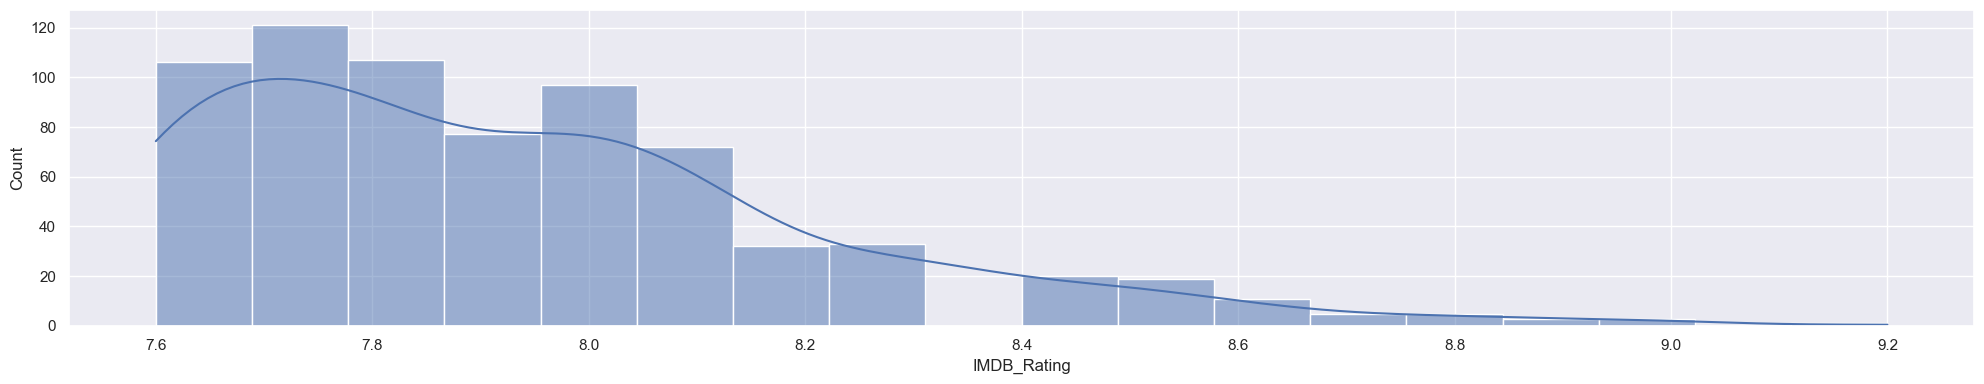

In [25]:
plt.figure(figsize = (20, 4))

ax = sns.histplot(x = 'IMDB_Rating', data = df4, kde = True)
plt.tight_layout();
plt.show;

* Na análise univariada, busca-se avaliar o comportamento da variável resposta. Neste caso, a distribuição do atributo é assimétrica à direita (assimetria positiva), ou seja, os dados estão mais concentrados no lado esquerdo da escala. Observa-se que a maioria dos filmes possui avaliação entre 7.6 e 8.1, enquanto poucos alcançam notas mais elevadas, acima de 9.0. A partir desse gráfico, é possível inferir que a variabilidade das notas é relativamente baixa, o que pode levar o modelo a produzir previsões próximas à média.

### 4.3 Análise univariada (variáveis preditoras)

#### 4.3.1 Variáveis numéricas

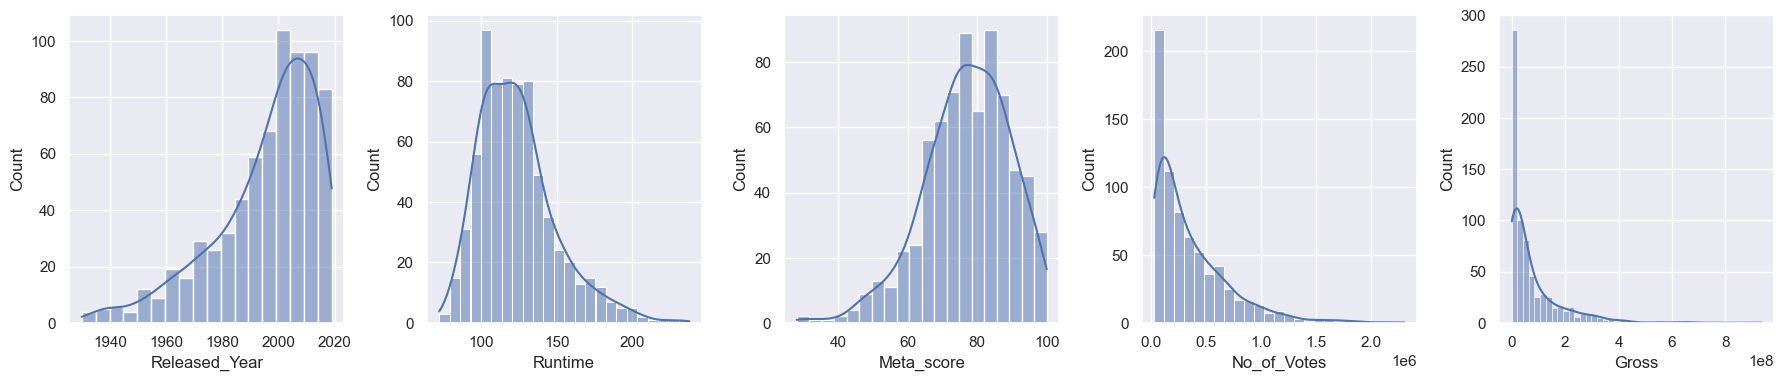

In [26]:
plt.figure(figsize = (22, 4))
grid = plt.GridSpec(1, 5, hspace = 0.5, wspace = 0.3)

plt.subplot(grid[0, 0])
sns.histplot(x = 'Released_Year', data = df4, kde = True)

plt.subplot(grid[0, 1])
sns.histplot(x = 'Runtime', data = df4, kde = True)

plt.subplot(grid[0, 2])
sns.histplot(x = 'Meta_score', data = df4, kde = True)

plt.subplot(grid[0, 3])
sns.histplot(x = 'No_of_Votes', data = df4, kde = True)

plt.subplot(grid[0, 4])
sns.histplot(x = 'Gross', data = df4, kde = True)

plt.tight_layout()
plt.show();

* Conforme identificado na análise descritiva, as colunas 'Series_Title' e 'Overview' possuem valores únicos para cada observação, indicando que cada filme possui título e descrição individualizados.
O primeiro gráfico mostra que houve um aumento constante no número de lançamentos a partir de 1940, atingindo um pico por volta do ano 2000, após esse pico, a quantidade de filmes lançados diminuiu um pouco, sugerindo que a produção de filmes foi mais intensa na virada do século. A maior parte dos filmes tem uma duração entre 100 e 150 min., com o valor mais frequente de 120 min., diante disto, filmes muito curtos ou muito longos são menos comuns. O pico da curva está em um valor relativamente alto, indicando que a maioria dos filmes tem uma pontuação entre 60 e 80. Isso sugere que grande parte dos filmes nesta base de dados recebeu críticas positivas. A distribuição do número de votos que cada filme recebeu mostra que a maior parte dos filmes teve um número muito baixo de votos, outro ponto é que poucos filmes receberam uma quantidade extremamente alta de votos, acredito que isso era o esperado, já que apenas um pequeno número de filmes se torna viral. O último gráfico exibe a distribuição da bilheteria (arrecadação total), assim como no gráfico de votos, a distribuição é muito concentrada à esquerda, mostrando que a grande maioria dos filmes tem uma bilheteria relativamente baixa e poucos filmes arrecadaram valores extremamente altos.

#### 4.3.2 Variáveis categóricas

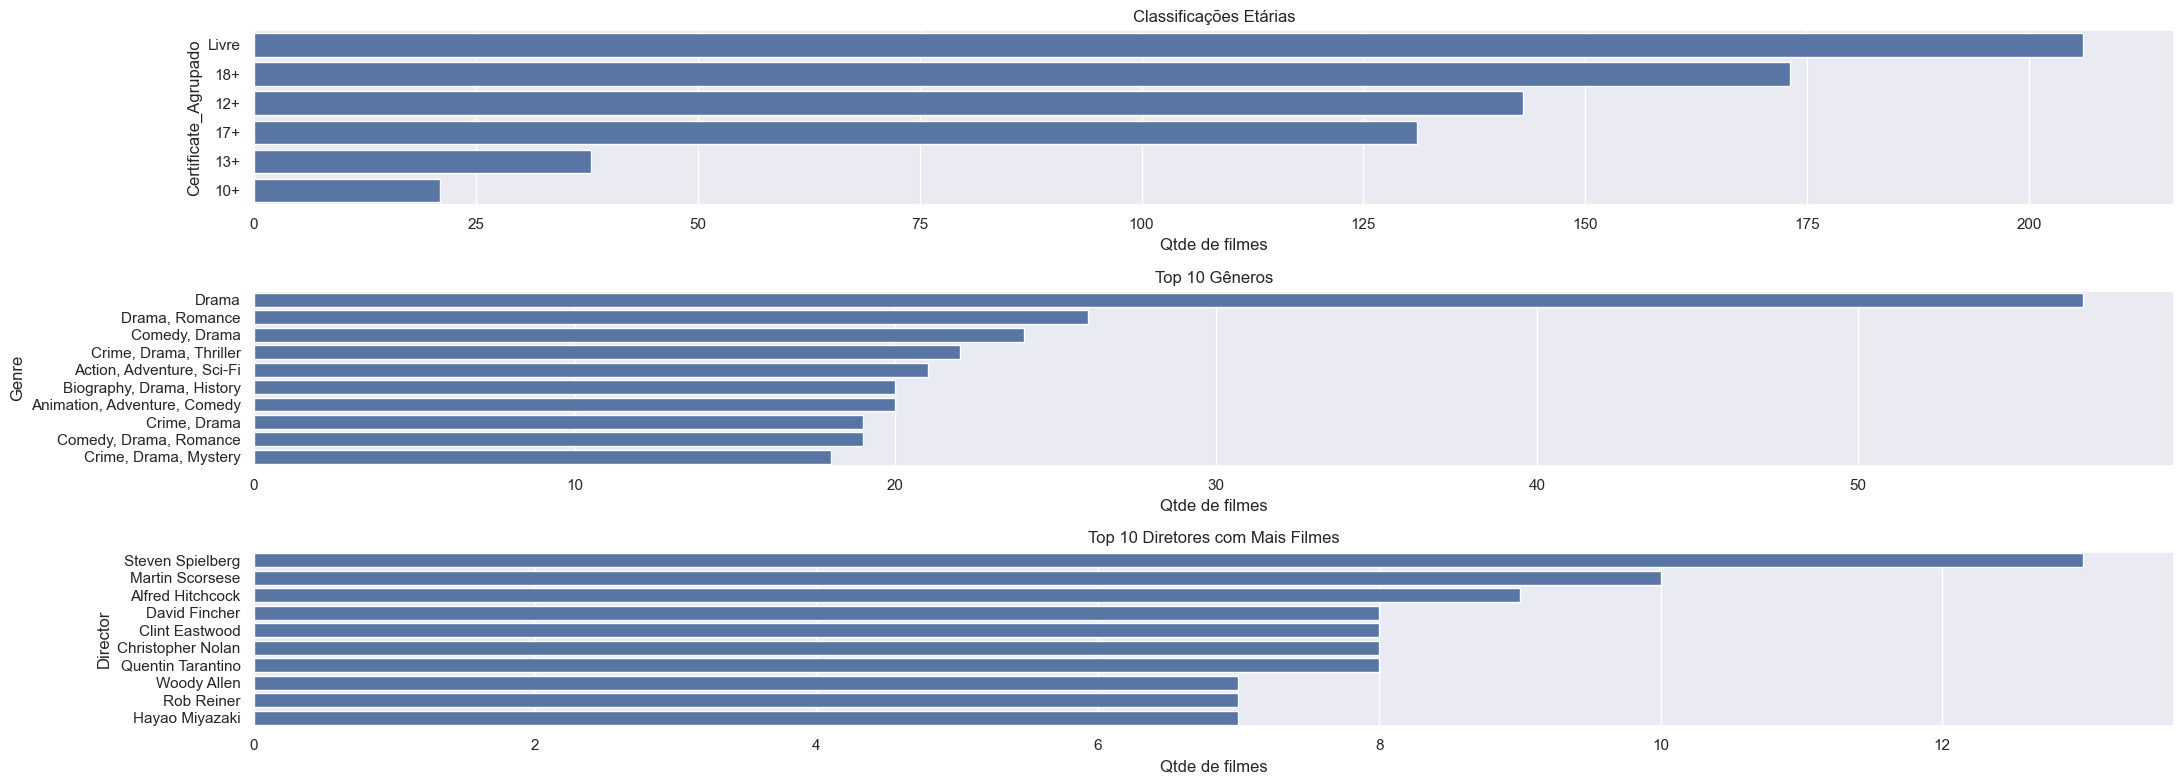

In [27]:
plt.figure(figsize = (22, 8))
grid = plt.GridSpec(3, 1)

plt.subplot(grid[0, 0])
cert_order = df4['Certificate_Agrupado'].value_counts().index
sns.countplot(y = 'Certificate_Agrupado', data = df4, order = cert_order)
plt.title('Classificações Etárias')
plt.xlabel('Qtde de filmes')

plt.subplot(grid[1, 0])
top_genres = df4['Genre'].value_counts().head(10).index
sns.countplot(y = 'Genre', data = df4[df4['Genre'].isin(top_genres)], order = top_genres)
plt.title('Top 10 Gêneros')
plt.xlabel('Qtde de filmes')

plt.subplot(grid[2, 0])
top_directors = df4['Director'].value_counts().head(10).index
sns.countplot(y = 'Director', data = df4[df4['Director'].isin(top_directors)], order = top_directors)
plt.title('Top 10 Diretores com Mais Filmes')
plt.xlabel('Qtde de filmes')

plt.tight_layout()
plt.show();

* A classificação etária livre seguida de 18+ e 12+ concentram a maior parte dos filmes, ou seja, uma classificação mais voltada para a familia de um modo geral, a respeito do genero, drama é disparado o mais comum, sobre o diretor, o nome Steven Spielberg lidera com 13 filmes, sugerindo que diretores renomados possivelmente tem maior impacto em notas ou bilheterias. 

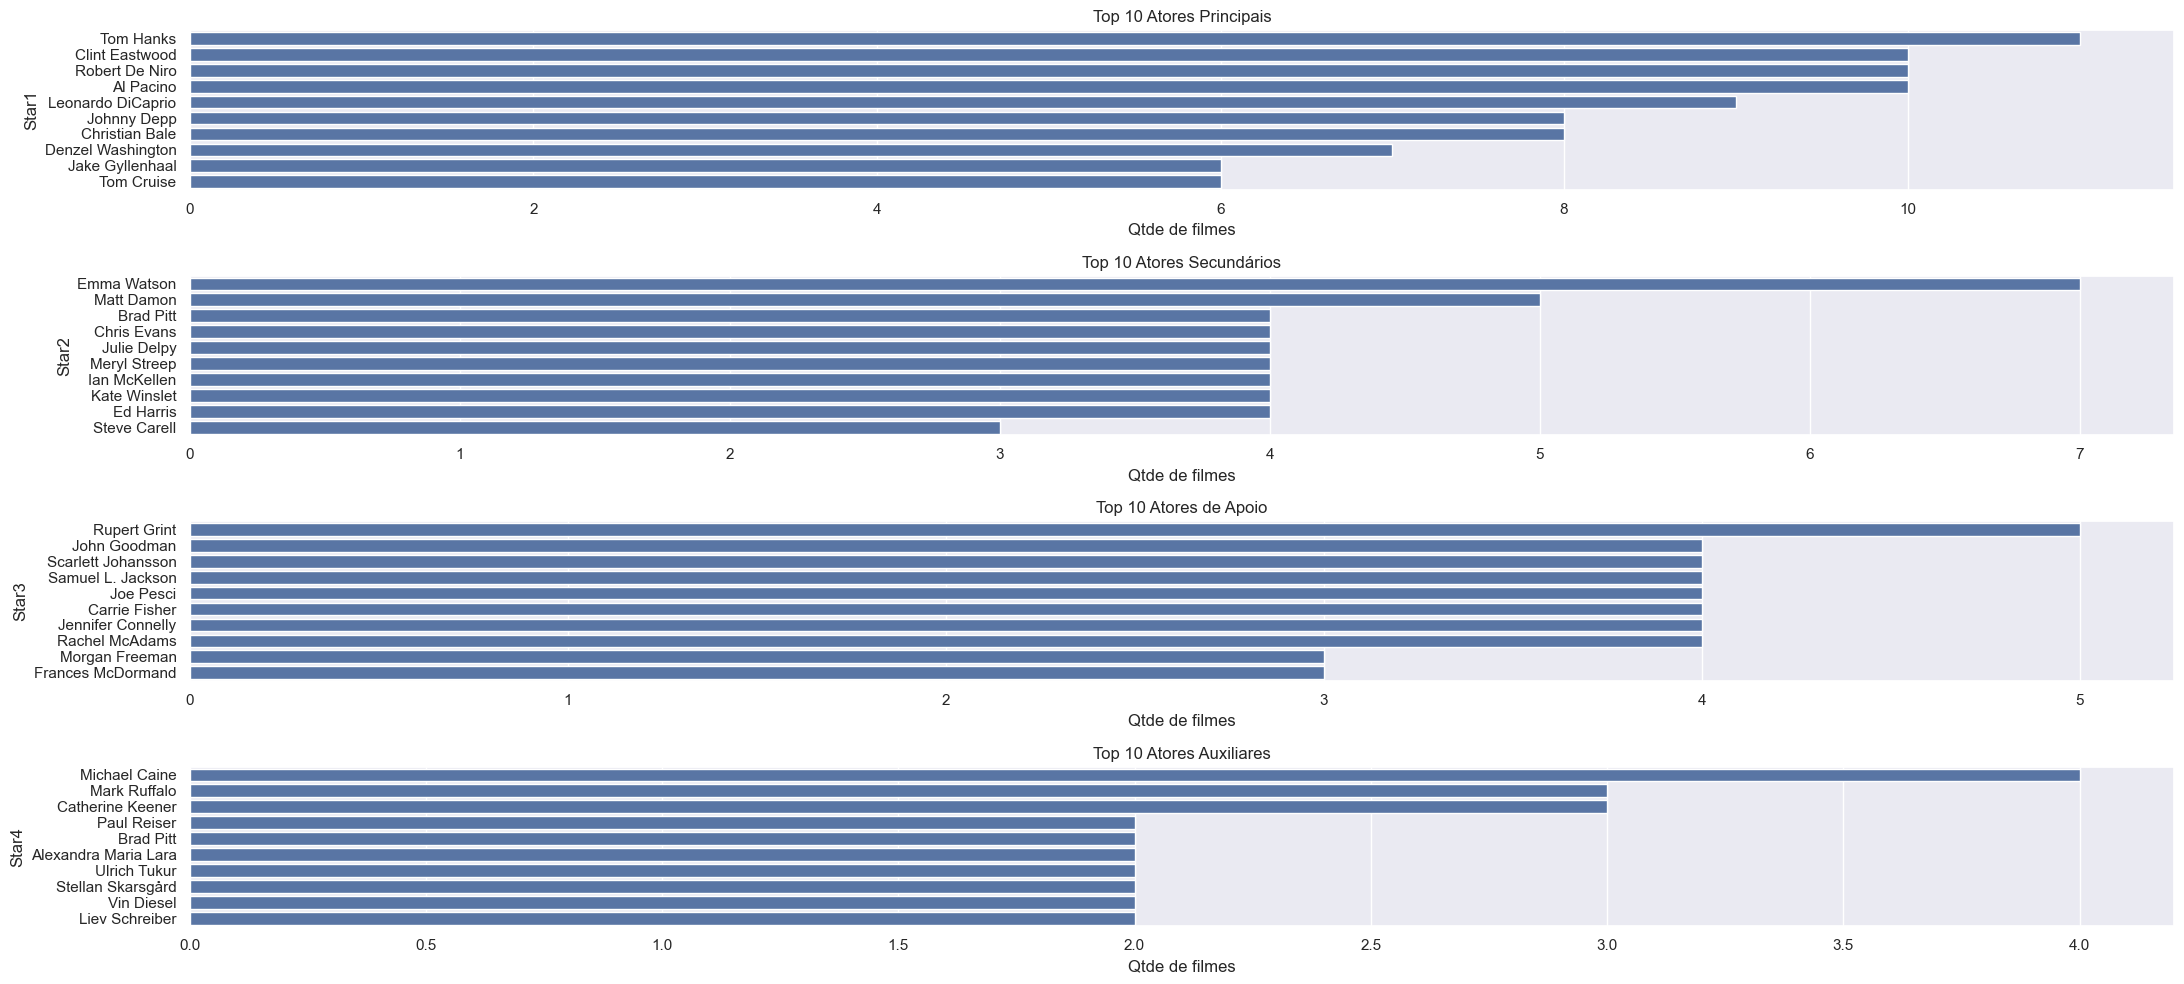

In [28]:
plt.figure(figsize = (22, 10))
grid = plt.GridSpec(4, 1)#, hspace = 0.8, wspace = 0.3)

plt.subplot(grid[0, 0])
top_star1 = df4['Star1'].value_counts().head(10).index
sns.countplot(y = 'Star1', data = df4[df4['Star1'].isin(top_star1)], order = top_star1)
plt.title('Top 10 Atores Principais')
plt.xlabel('Qtde de filmes')

plt.subplot(grid[1, 0])
top_star2 = df4['Star2'].value_counts().head(10).index
sns.countplot(y = 'Star2', data = df4[df4['Star2'].isin(top_star2)], order = top_star2)
plt.title('Top 10 Atores Secundários')
plt.xlabel('Qtde de filmes')

plt.subplot(grid[2, 0])
top_star3 = df4['Star3'].value_counts().head(10).index
sns.countplot(y = 'Star3', data = df4[df4['Star3'].isin(top_star3)], order = top_star3)
plt.title('Top 10 Atores de Apoio')
plt.xlabel('Qtde de filmes')

plt.subplot(grid[3, 0])
top_star4 = df4['Star4'].value_counts().head(10).index
sns.countplot(y = 'Star4', data = df4[df4['Star4'].isin(top_star4)], order = top_star4)
plt.title('Top 10 Atores Auxiliares')
plt.xlabel('Qtde de filmes')

plt.tight_layout()
plt.show();

* Entre os protagonistas, os atores masculinos predominam, com Tom Hanks (11), Clint Eastwood (10), Robert De Niro (10) e Al Pacino (10) aparecendo com maior frequência. Já entre os atores secundários, destaca-se a atriz Emma Watson (7), que lidera com expressiva vantagem. Nos papéis de apoio e auxiliares, as diferenças são menos acentuadas: Rupert Grint (5) aparece mais frequentemente, enquanto Michael Caine (4) lidera.

### 4.4 Verificar se existem outliers

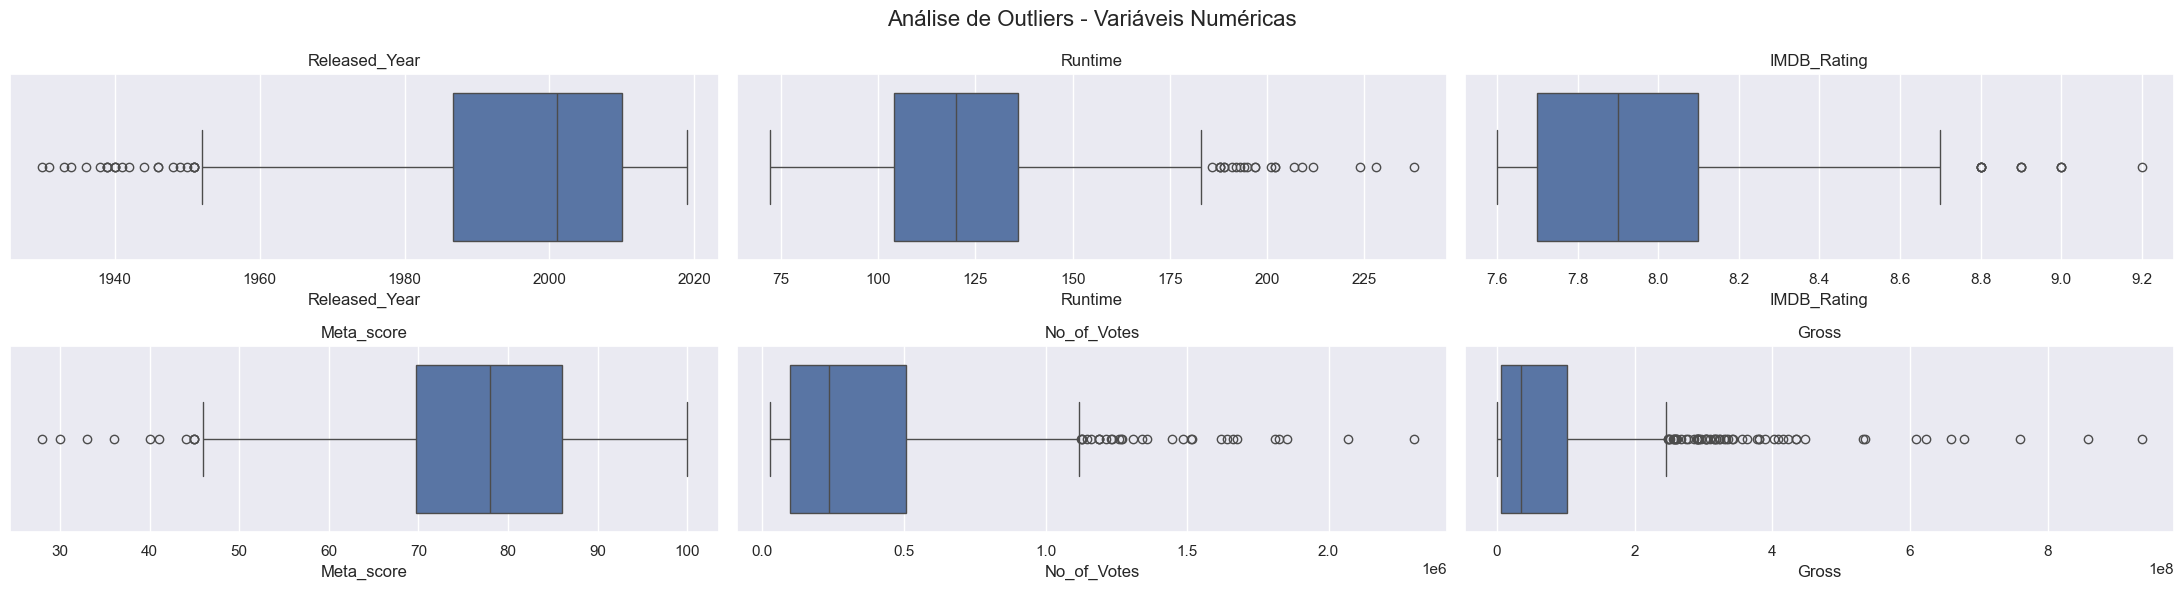

In [29]:
fig, axs = plt.subplots(2, 3, figsize = (22, 6))
fig.suptitle('Análise de Outliers - Variáveis Numéricas', fontsize = 16, y = 0.98)

sns.boxplot(x = 'Released_Year', data = df4, ax = axs[0, 0])
axs[0, 0].set_title('Released_Year')

sns.boxplot(x = 'Runtime', data = df4, ax = axs[0, 1])
axs[0, 1].set_title('Runtime')

sns.boxplot(x = 'IMDB_Rating', data = df4, ax = axs[0, 2])
axs[0, 2].set_title('IMDB_Rating')

sns.boxplot(x = 'Meta_score', data = df4, ax = axs[1, 0])
axs[1, 0].set_title('Meta_score')

sns.boxplot(x = 'No_of_Votes', data = df4, ax = axs[1, 1])
axs[1, 1].set_title('No_of_Votes')

sns.boxplot(x = 'Gross', data = df4, ax = axs[1, 2])
axs[1, 2].set_title('Gross')

plt.tight_layout()
plt.show();

* A análise do conjunto de dados revela algumas características importantes, por exemplo, filmes anteriores a 1960 aparecem como outliers, o que evidencia uma frequência muito menor e indica que há poucos filmes antigos em relação ao total. Em relação à duração, filmes com mais de 180 minutos são considerados longos, já que a duração média é de aproximadamente 120 minutos. Quanto às notas, observa-se uma concentração na faixa de 7.7 a 8.1, com uma mediana de 7.9. No que diz respeito ao número de votos, a maioria dos filmes recebeu até 500 mil votos, sendo que aqueles com mais de 1 milhão de votos geralmente são considerados muito populares. Por fim, a distribuição da bilheteria é altamente assimétrica à direita, o que significa que, enquanto poucos filmes arrecadam valores excepcionais, a grande maioria tem uma receita mais modesta.

### 4.5 Análise bivariada

#### 4.5.1 Avaliar correlação entre as variáveis e a arrecadação do filme

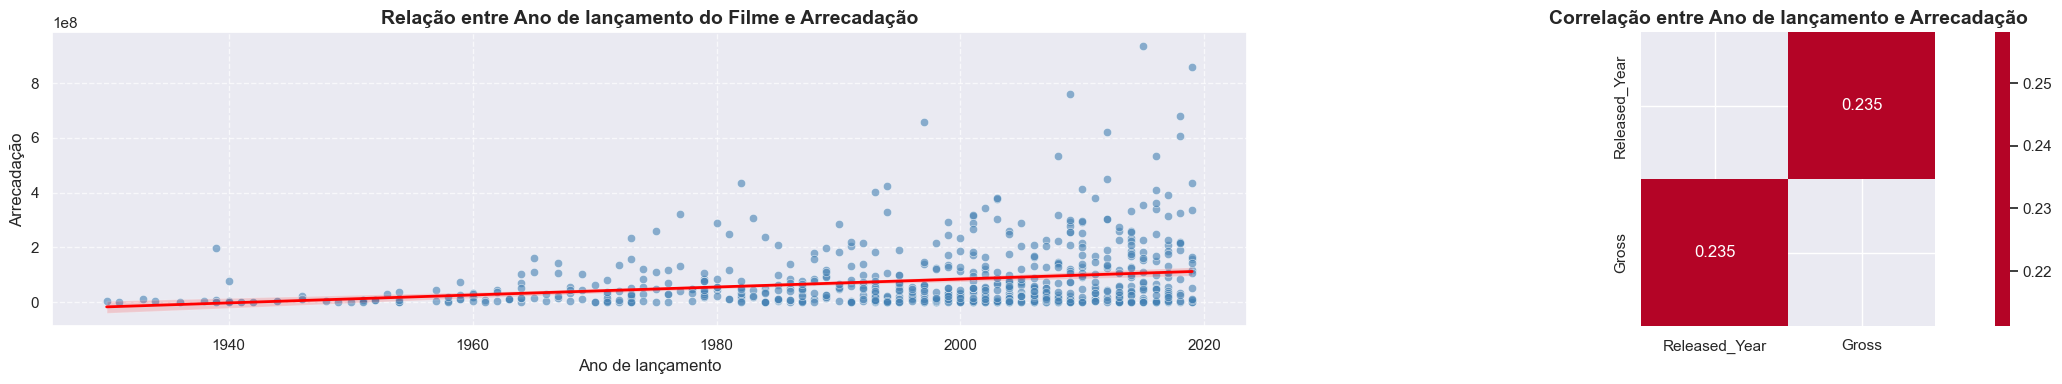

In [30]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'Released_Year', y = 'Gross', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'Released_Year', y = 'Gross', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre Ano de lançamento do Filme e Arrecadação', fontsize = 14, fontweight = 'bold')
plt.xlabel('Ano de lançamento')
plt.ylabel('Arrecadação')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

duracao_votos = df4['Released_Year'].corr(df4['Gross'])
correlation_matrix = pd.DataFrame([[1, duracao_votos], 
                                  [duracao_votos, 1]],
                                 columns = ['Released_Year', 'Gross'], 
                                 index = ['Released_Year', 'Gross'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre Ano de lançamento e Arrecadação', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

* Existe uma correlação positiva (0,235) considerada fraca, ou seja, filmes mais recentes tendem a arrecadar um pouco mais, mas somente esta variável não é um fator relevante.

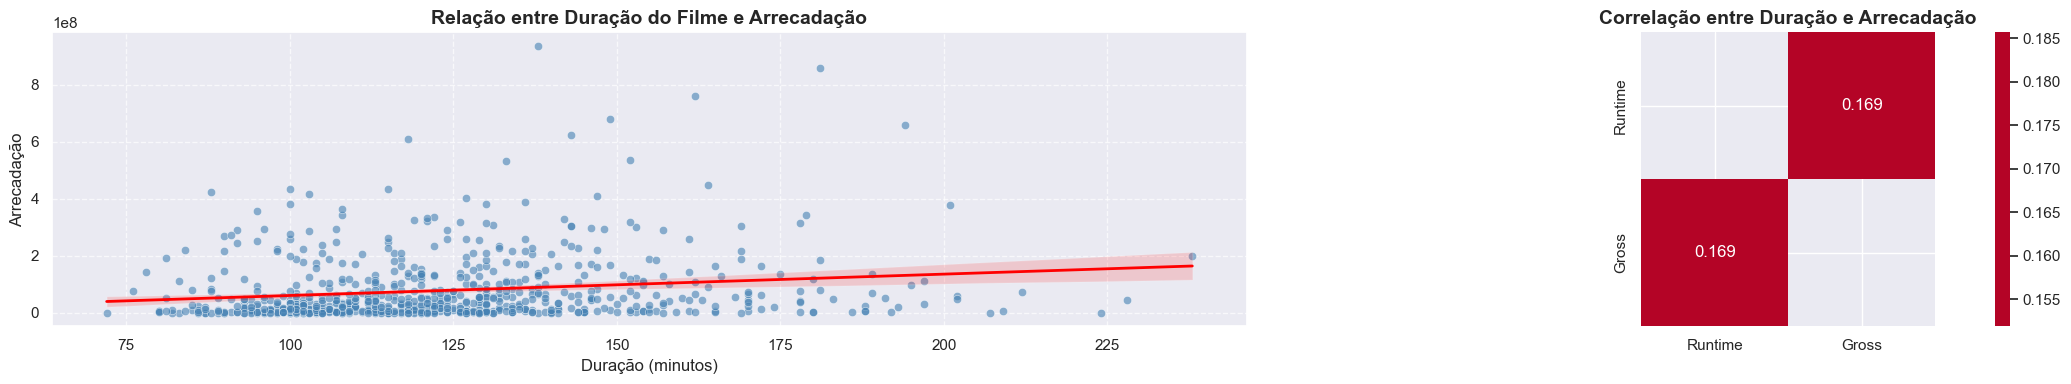

In [31]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'Runtime', y = 'Gross', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'Runtime', y = 'Gross', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre Duração do Filme e Arrecadação', fontsize = 14, fontweight = 'bold')
plt.xlabel('Duração (minutos)')
plt.ylabel('Arrecadação')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

duracao_votos = df4['Runtime'].corr(df4['Gross'])
correlation_matrix = pd.DataFrame([[1, duracao_votos], 
                                  [duracao_votos, 1]],
                                 columns = ['Runtime', 'Gross'], 
                                 index = ['Runtime', 'Gross'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre Duração e Arrecadação', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

* Existe uma correlação positiva (0,169) considerada fraca, ou seja, filmes mais longos tendem a arrecadar levemente mais, mas a duração não é um fator relevante isoladamente.

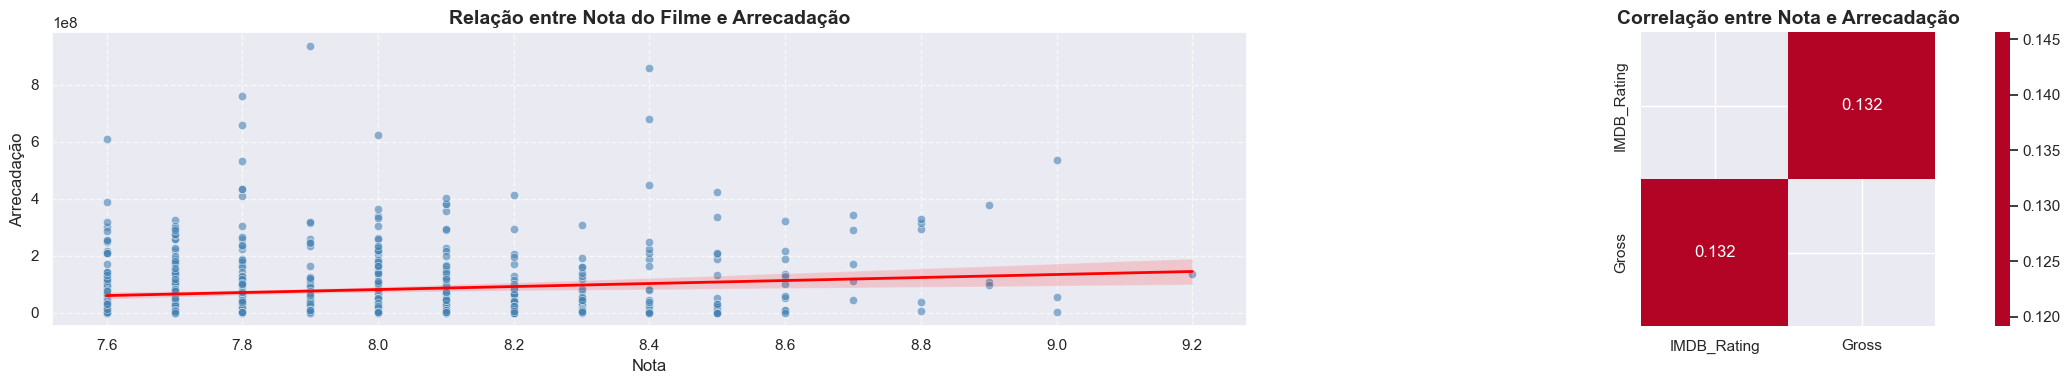

In [32]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'IMDB_Rating', y = 'Gross', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'IMDB_Rating', y = 'Gross', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre Nota do Filme e Arrecadação', fontsize = 14, fontweight = 'bold')
plt.xlabel('Nota')
plt.ylabel('Arrecadação')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

duracao_votos = df4['IMDB_Rating'].corr(df4['Gross'])
correlation_matrix = pd.DataFrame([[1, duracao_votos], 
                                  [duracao_votos, 1]],
                                 columns = ['IMDB_Rating', 'Gross'], 
                                 index = ['IMDB_Rating', 'Gross'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre Nota e Arrecadação', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

* A relação entre nota do filme e arrecadação existe, mas é positiva (0,132) fraca, isso significa que filmes com avaliações mais altas tendem a arrecadar levemente mais, contudo não garante sucesso na arrecadação.

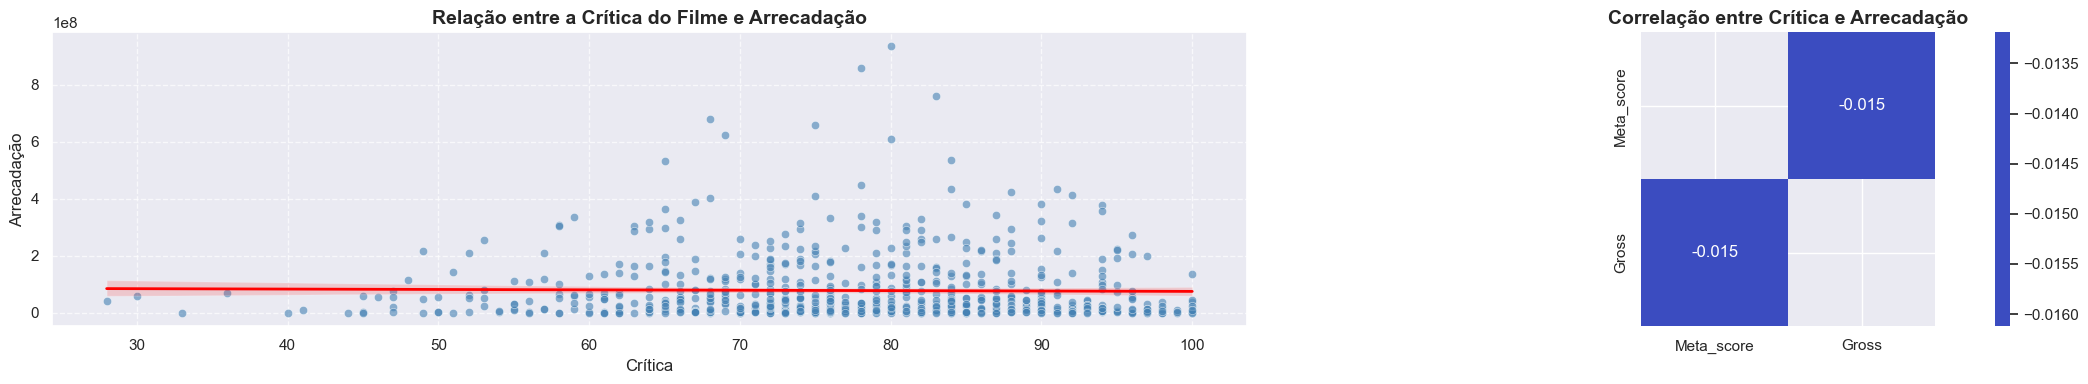

In [33]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'Meta_score', y = 'Gross', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'Meta_score', y = 'Gross', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre a Crítica do Filme e Arrecadação', fontsize = 14, fontweight = 'bold')
plt.xlabel('Crítica')
plt.ylabel('Arrecadação')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

duracao_votos = df4['Meta_score'].corr(df4['Gross'])
correlation_matrix = pd.DataFrame([[1, duracao_votos], 
                                  [duracao_votos, 1]],
                                 columns = ['Meta_score', 'Gross'], 
                                 index = ['Meta_score', 'Gross'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre Crítica e Arrecadação', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

* A relação entre crítica e arrecadação é praticamente inexistente (-0,015), isso evidência que a avaliação da crítica não é um fator que influencia no sucesso de bilheteria.

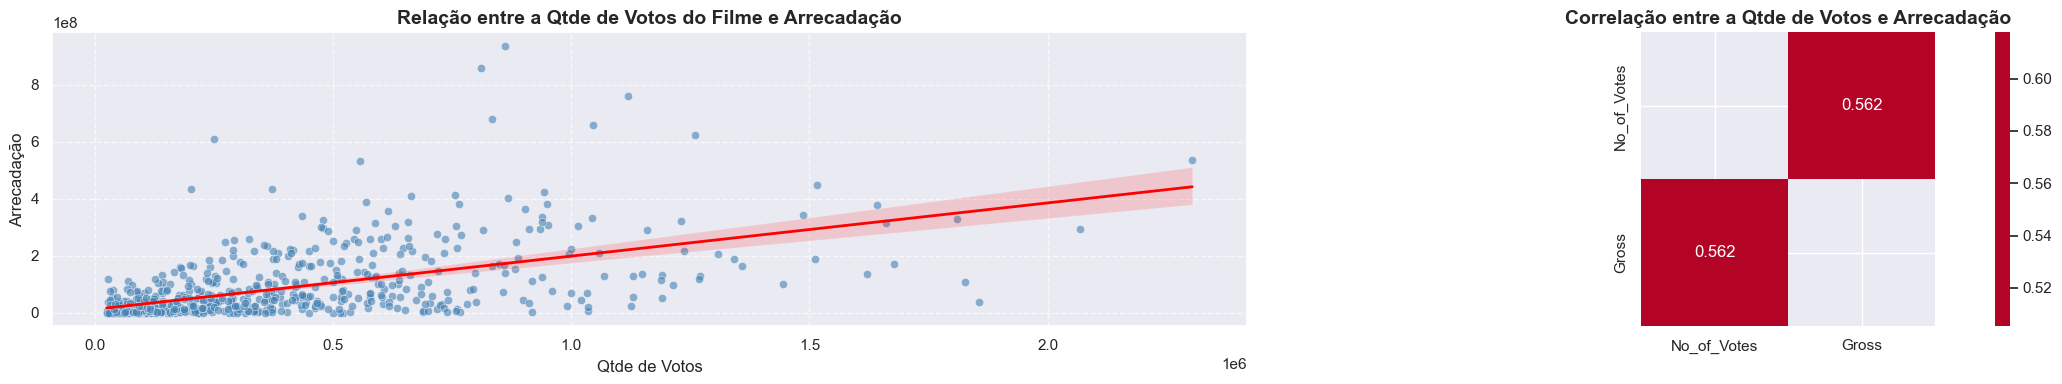

In [34]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'No_of_Votes', y = 'Gross', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'No_of_Votes', y = 'Gross', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre a Qtde de Votos do Filme e Arrecadação', fontsize = 14, fontweight = 'bold')
plt.xlabel('Qtde de Votos')
plt.ylabel('Arrecadação')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

duracao_votos = df4['No_of_Votes'].corr(df4['Gross'])
correlation_matrix = pd.DataFrame([[1, duracao_votos], 
                                  [duracao_votos, 1]],
                                 columns = ['No_of_Votes', 'Gross'], 
                                 index = ['No_of_Votes', 'Gross'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre a Qtde de Votos e Arrecadação', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

* A quantidade de votos apresenta a correlação mais alta com a arrecadação (0,562), mostrando uma relação moderada a forte, em outras palavras, filmes com maior bilheteria tendem a receber mais votos, refletindo maior alcance e engajamento do público.

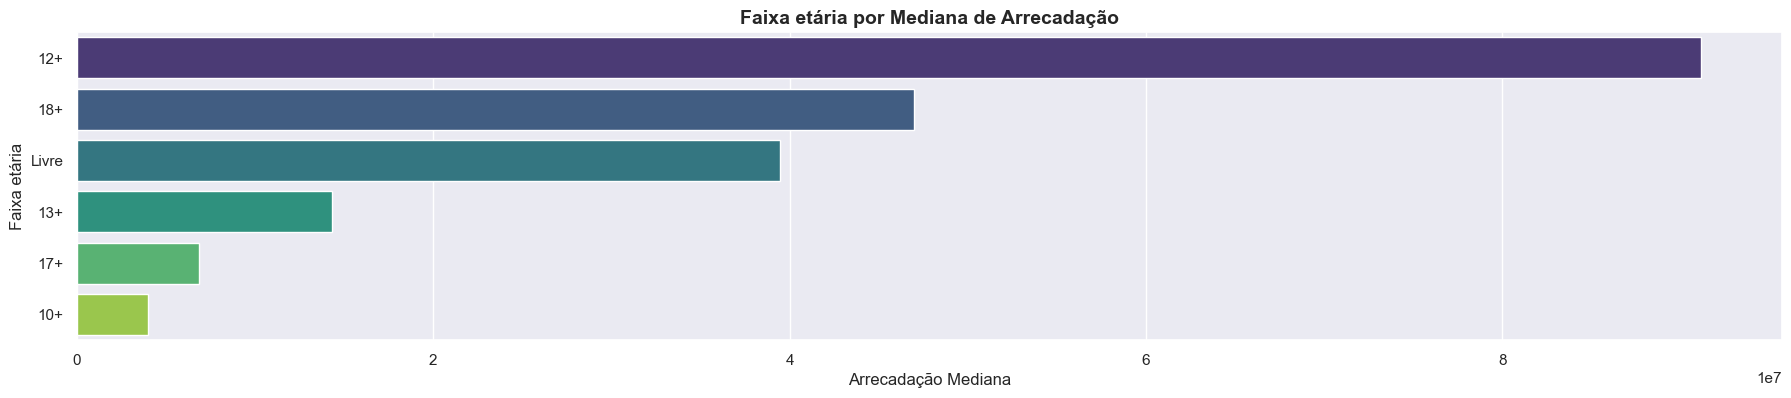

In [35]:
plt.figure(figsize = (22, 4))
gross_por_faixa_etaria = df4.groupby("Certificate_Agrupado")["Gross"].median().sort_values(ascending = False)
sns.barplot(x = gross_por_faixa_etaria.values, y = gross_por_faixa_etaria.index, palette = "viridis")
plt.title("Faixa etária por Mediana de Arrecadação", fontsize = 14, fontweight = "bold")
plt.xlabel("Arrecadação Mediana")
plt.ylabel("Faixa etária")
plt.show();

* Filmes das faixas etárias 12+, 18+ e livre respectivamente tendem a ter mediana de arrecadação maior.

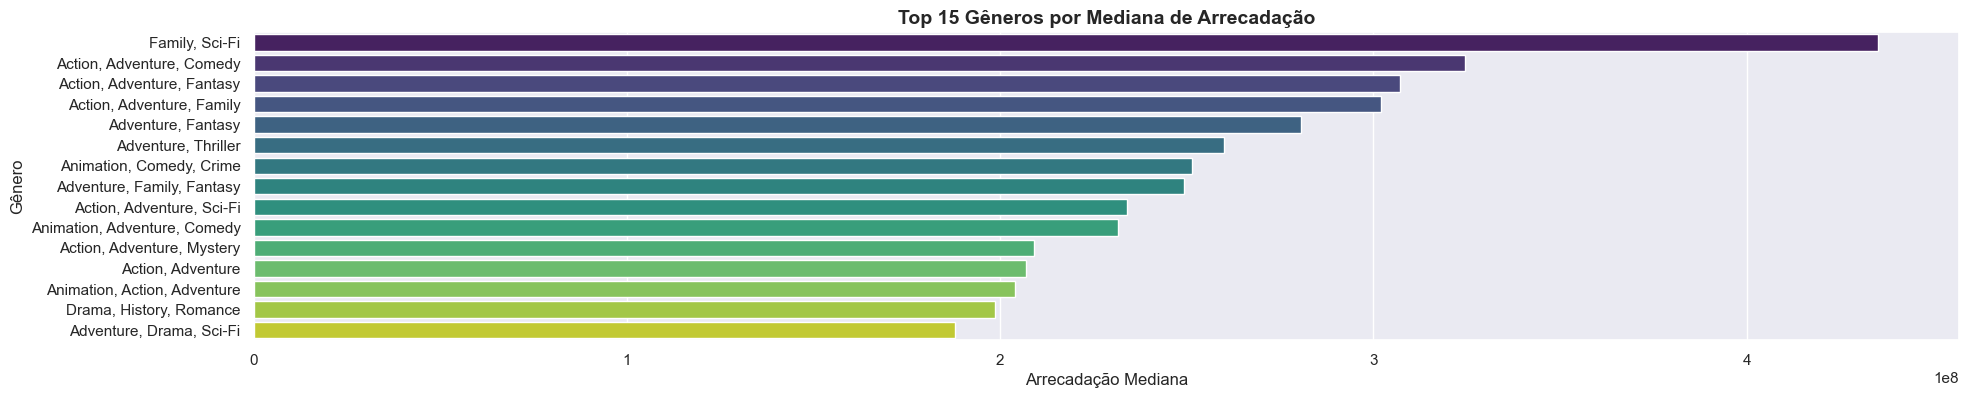

In [36]:
plt.figure(figsize = (22, 4))
gross_por_genero = df4.groupby("Genre")["Gross"].median().sort_values(ascending = False).head(15)
sns.barplot(x = gross_por_genero.values, y = gross_por_genero.index, palette = "viridis")
plt.title("Top 15 Gêneros por Mediana de Arrecadação", fontsize = 14, fontweight = "bold")
plt.xlabel("Arrecadação Mediana")
plt.ylabel("Gênero")
plt.show();

* Filmes do gênero familiar, ação e aventura, especialmente quando combinados com comédia ou ficção científica, tendem a ter a maior mediana de arrecadação.

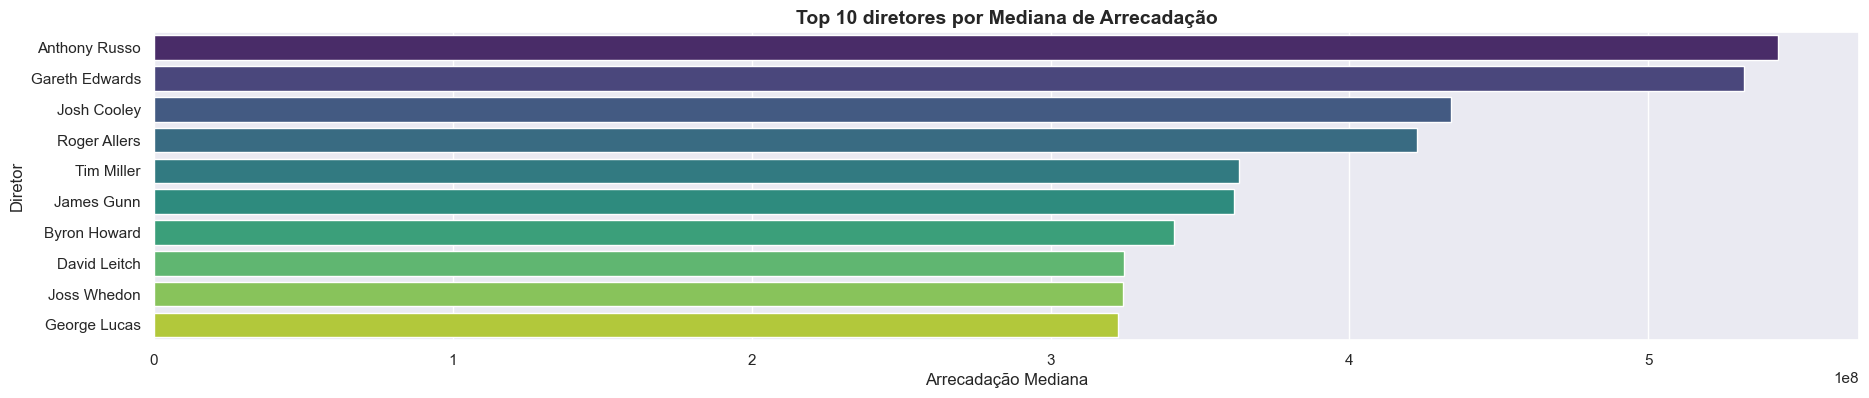

In [37]:
plt.figure(figsize = (22, 4))
gross_por_diretor = df4.groupby("Director")["Gross"].median().sort_values(ascending = False).head(10)
sns.barplot(x = gross_por_diretor.values, y = gross_por_diretor.index, palette = "viridis")
plt.title("Top 10 diretores por Mediana de Arrecadação", fontsize = 14, fontweight = "bold")
plt.xlabel("Arrecadação Mediana")
plt.ylabel("Diretor")
plt.show();

* Antony Russo seguido de Gareth Edwards são os diretores respectivamente com tendência das maiores medianas de arrecadação, significativamente à frente de todos os outros na lista.

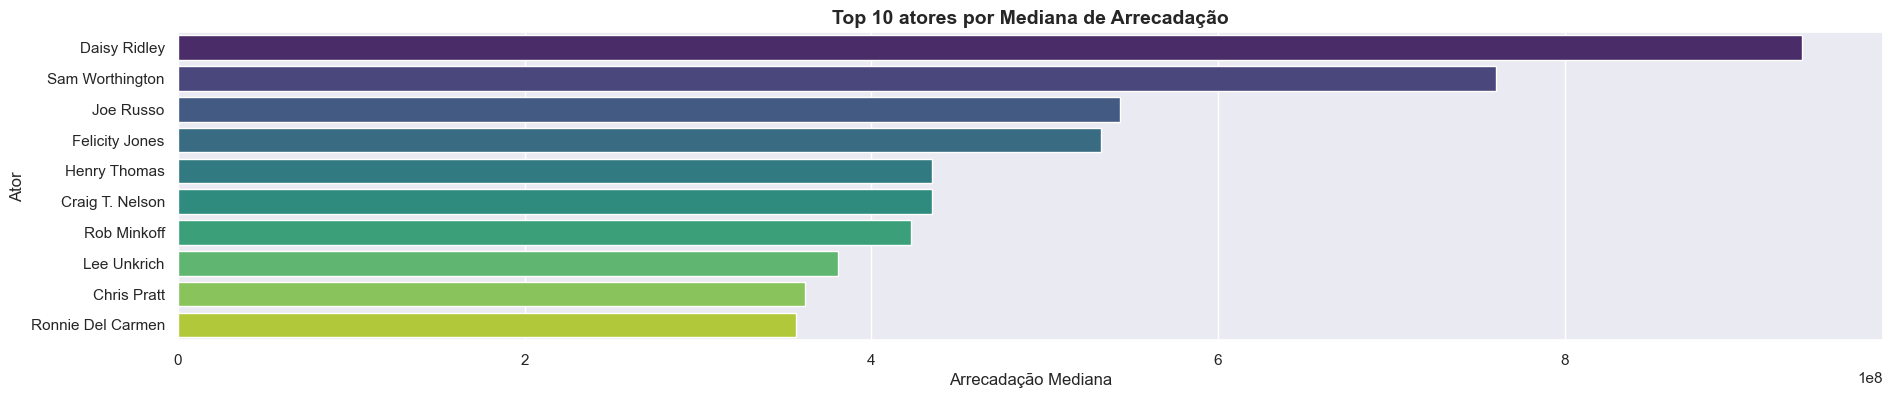

In [38]:
plt.figure(figsize = (22, 4))
gross_por_ator_1 = df4.groupby("Star1")["Gross"].median().sort_values(ascending = False).head(10)
sns.barplot(x = gross_por_ator_1.values, y = gross_por_ator_1.index, palette = "viridis")
plt.title("Top 10 atores por Mediana de Arrecadação", fontsize = 14, fontweight = "bold")
plt.xlabel("Arrecadação Mediana")
plt.ylabel("Ator")
plt.show();

* Daisy Ridley e Sam Wothington são os atores respectivamente com tendência das maiores medianas de arrecadação, bem à frente de todos os outros na lista.

#### 4.5.1 Validar ou refutar as hipóteses

**1.** Filmes mais longos tendem a ter notas mais altas?

**Verdadeira** Existe uma correlação positiva (0,259) considerada fraca de que filmes mais longos tem notas mais altas.

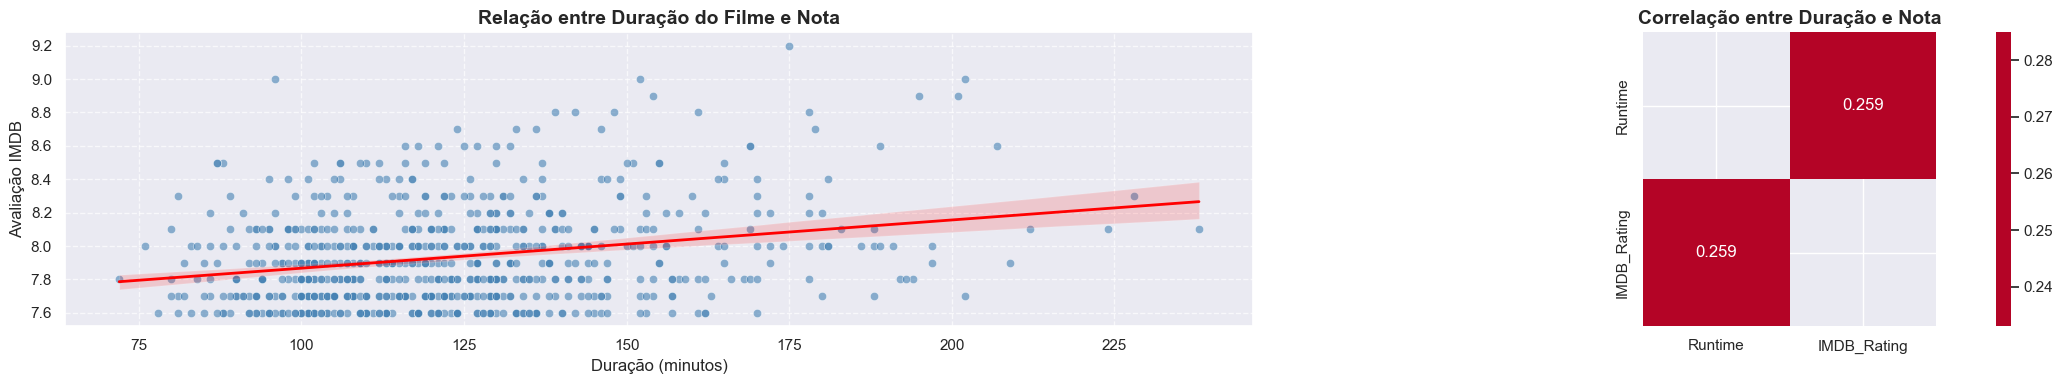

In [39]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'Runtime', y = 'IMDB_Rating', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'Runtime', y = 'IMDB_Rating', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre Duração do Filme e Nota', fontsize = 14, fontweight = 'bold')
plt.xlabel('Duração (minutos)')
plt.ylabel('Avaliação IMDB')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

duracao_votos = df4['Runtime'].corr(df4['IMDB_Rating'])
correlation_matrix = pd.DataFrame([[1, duracao_votos], 
                                  [duracao_votos, 1]],
                                 columns = ['Runtime', 'IMDB_Rating'], 
                                 index = ['Runtime', 'IMDB_Rating'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre Duração e Nota', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

**2.** Filmes com mais votos têm notas mais altas?

**Verdadeira** Existe uma correlação positiva (0,609) considerada moderada de que filmes com mais votos tem notas mais altas.

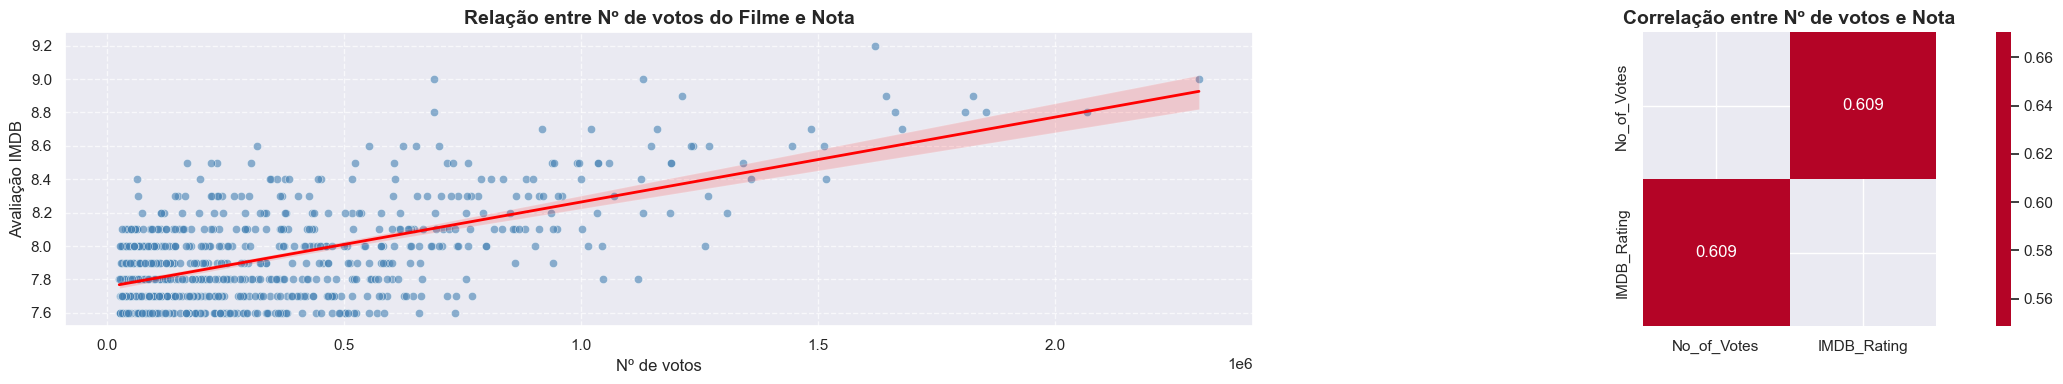

In [40]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'No_of_Votes', y = 'IMDB_Rating', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'No_of_Votes', y = 'IMDB_Rating', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre Nº de votos do Filme e Nota', fontsize = 14, fontweight = 'bold')
plt.xlabel('Nº de votos')
plt.ylabel('Avaliação IMDB')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

correlacao_votos = df4['No_of_Votes'].corr(df4['IMDB_Rating'])
correlation_matrix = pd.DataFrame([[1, correlacao_votos], 
                                  [correlacao_votos, 1]],
                                 columns = ['No_of_Votes', 'IMDB_Rating'], 
                                 index = ['No_of_Votes', 'IMDB_Rating'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre Nº de votos e Nota', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

**3.** Existe uma correlação positiva entre críticas e notas?

**Verdadeira** Existe uma correlação positiva (0,284) considerada fraca de que filmes com avaliação de críticas maiores tem notas mais altas.

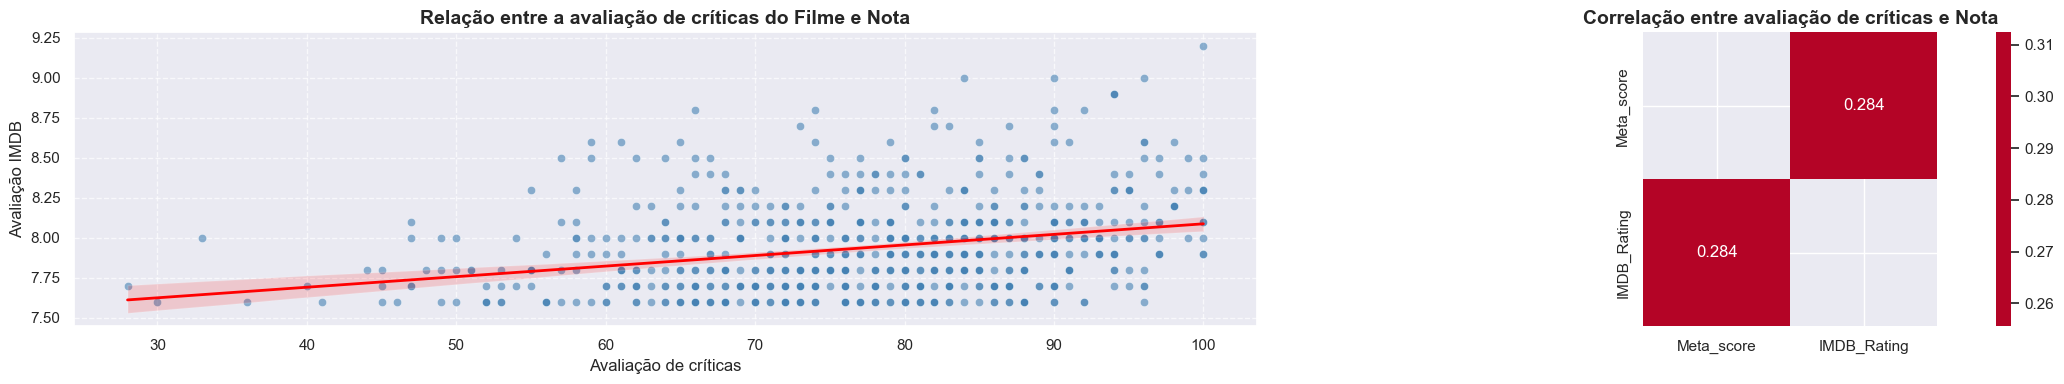

In [41]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'Meta_score', y = 'IMDB_Rating', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'Meta_score', y = 'IMDB_Rating', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre a avaliação de críticas do Filme e Nota', fontsize = 14, fontweight = 'bold')
plt.xlabel('Avaliação de críticas')
plt.ylabel('Avaliação IMDB')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

correlacao_votos = df4['Meta_score'].corr(df4['IMDB_Rating'])
correlation_matrix = pd.DataFrame([[1, correlacao_votos], 
                                  [correlacao_votos, 1]],
                                 columns = ['Meta_score', 'IMDB_Rating'], 
                                 index = ['Meta_score', 'IMDB_Rating'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre avaliação de críticas e Nota', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

**4.** Filmes mais recentes têm notas mais altas?

**Falsa** Não existe uma correlação positiva e sim uma negativa (0,179), ou seja, quanto mais velho o filme melhor é sua nota.

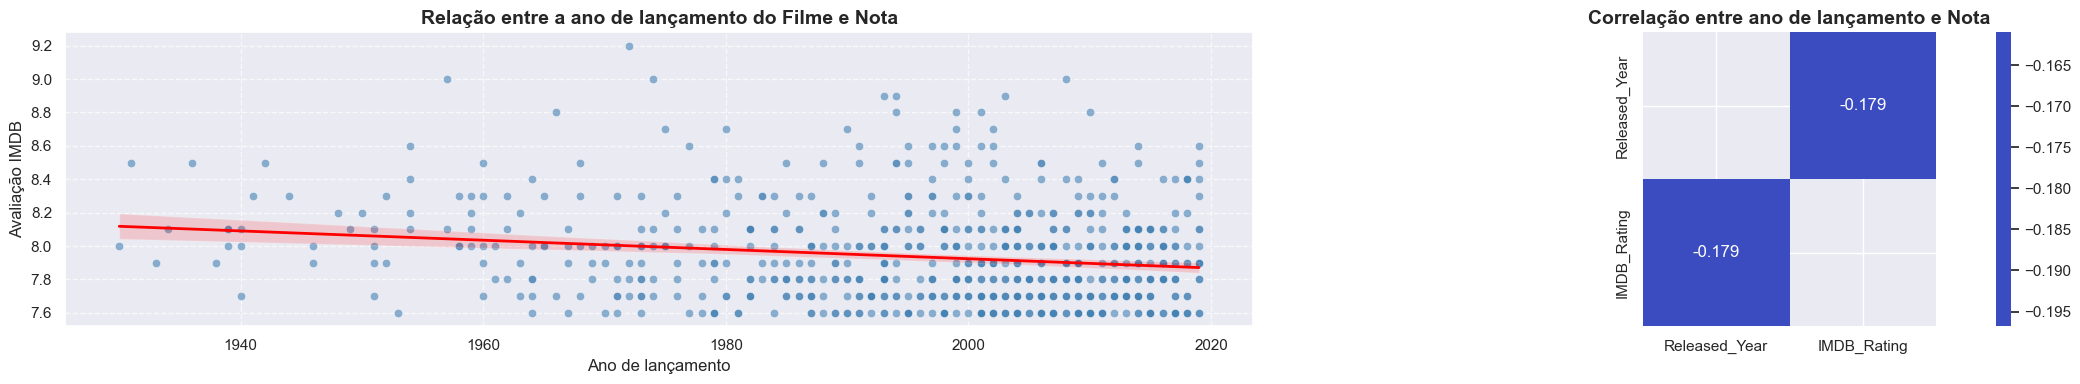

In [42]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'Released_Year', y = 'IMDB_Rating', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'Released_Year', y = 'IMDB_Rating', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre a ano de lançamento do Filme e Nota', fontsize = 14, fontweight = 'bold')
plt.xlabel('Ano de lançamento')
plt.ylabel('Avaliação IMDB')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

correlacao_votos = df4['Released_Year'].corr(df4['IMDB_Rating'])
correlation_matrix = pd.DataFrame([[1, correlacao_votos], 
                                  [correlacao_votos, 1]],
                                 columns = ['Released_Year', 'IMDB_Rating'], 
                                 index = ['Released_Year', 'IMDB_Rating'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre ano de lançamento e Nota', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

**5.** Certos gêneros têm notas médias mais altas?

**Verdadeira** Sim, gêneros como Drama (498 filmes) demostram notas médias superiores, indicando que certas categorias tendem a serem melhor avaliados.

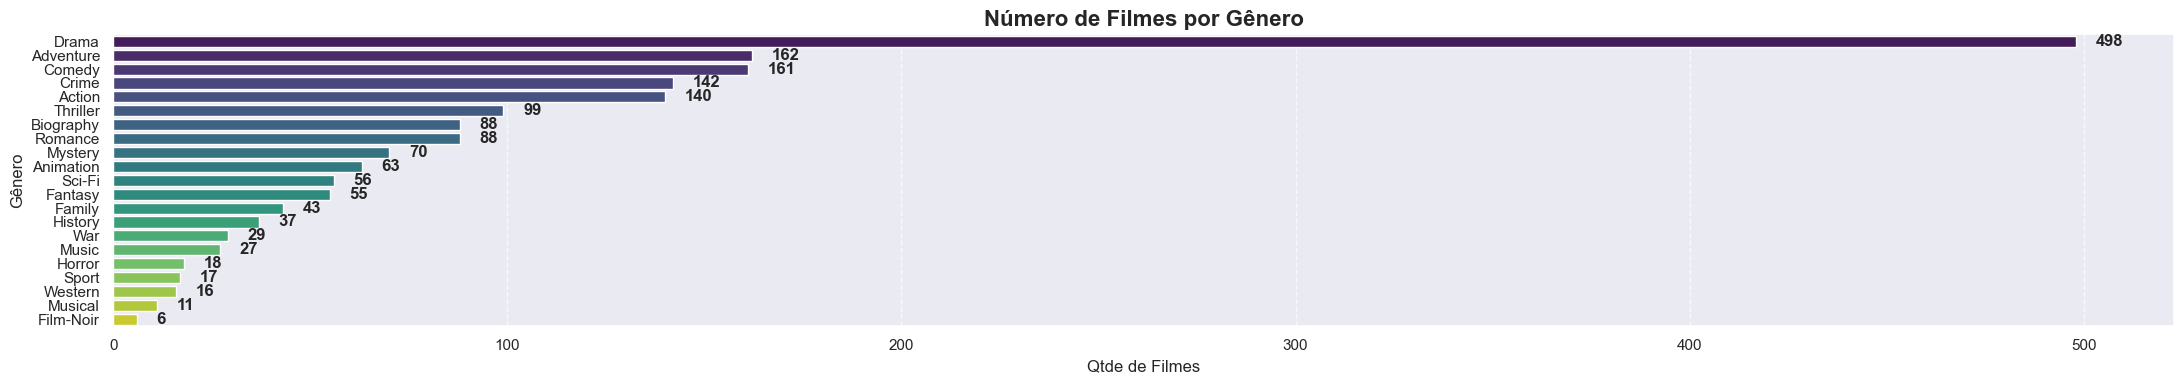

In [43]:
plt.figure(figsize = (22, 4))

df_generos = df4.copy()

df_generos['Genre'] = df_generos['Genre'].str.split(', ')
df_generos = df_generos.explode('Genre')

contagem_generos = df_generos['Genre'].value_counts()

sns.barplot(x = contagem_generos.values, y = contagem_generos.index, 
            palette = 'viridis', orient = 'h')

plt.title('Número de Filmes por Gênero', fontsize = 16, fontweight = 'bold')
plt.xlabel('Qtde de Filmes')
plt.ylabel('Gênero')
plt.grid(True, linestyle = '--', alpha = 0.7, axis = 'x')

for i, value in enumerate(contagem_generos.values):
    plt.text(value + 5, i, f'{value}', va = 'center', fontweight = 'bold')

plt.tight_layout()
plt.show();

**6.** Filmes com notas mais altas têm maior bilheteria?

**Verdadeira** Existe uma correlação positiva (0,132) considerada fraca de que filmes com maior bilheteria tem notas mais altas.

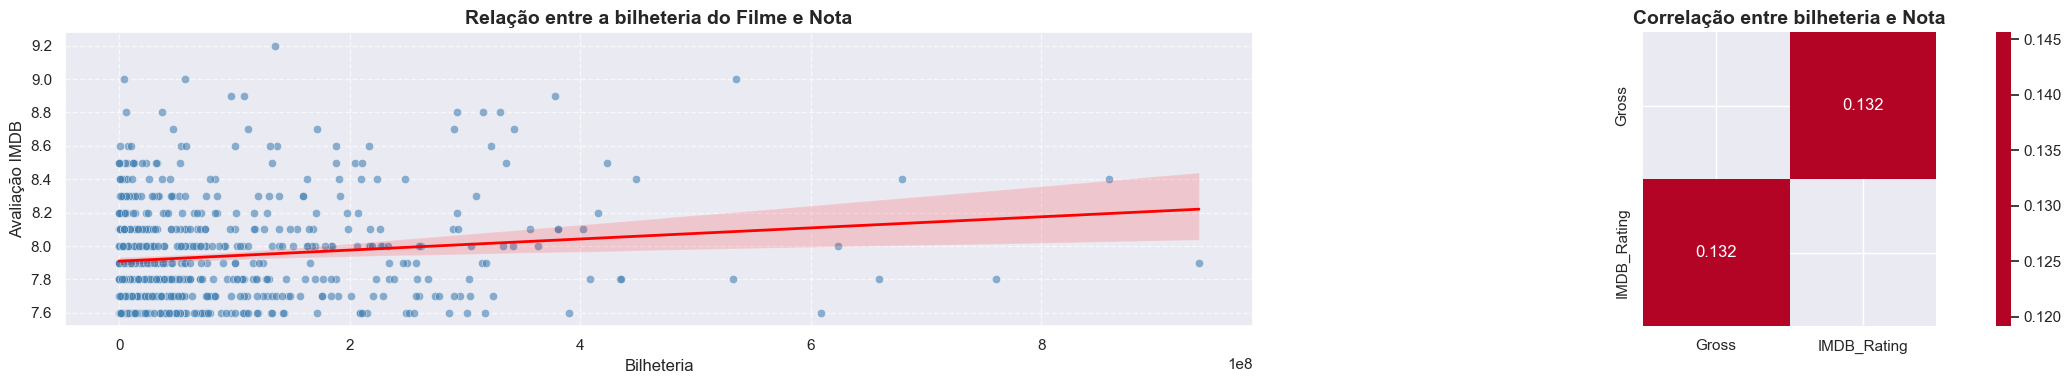

In [44]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'Gross', y = 'IMDB_Rating', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'Gross', y = 'IMDB_Rating', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre a bilheteria do Filme e Nota', fontsize = 14, fontweight = 'bold')
plt.xlabel('Bilheteria')
plt.ylabel('Avaliação IMDB')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

correlacao_votos = df4['Gross'].corr(df4['IMDB_Rating'])
correlation_matrix = pd.DataFrame([[1, correlacao_votos], 
                                  [correlacao_votos, 1]],
                                 columns = ['Gross', 'IMDB_Rating'], 
                                 index = ['Gross', 'IMDB_Rating'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre bilheteria e Nota', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

**7.** Filmes com elenco estrelado Star1 têm maior faturamento em relação aos filmes com elenco Star4?

**Falsa** Filmes com atores classificados como Star4 apresentam em média um faturamento um pouco maior frente aos atores Star1, indicando que a classificação do ator não garante um faturamento maior por si só.

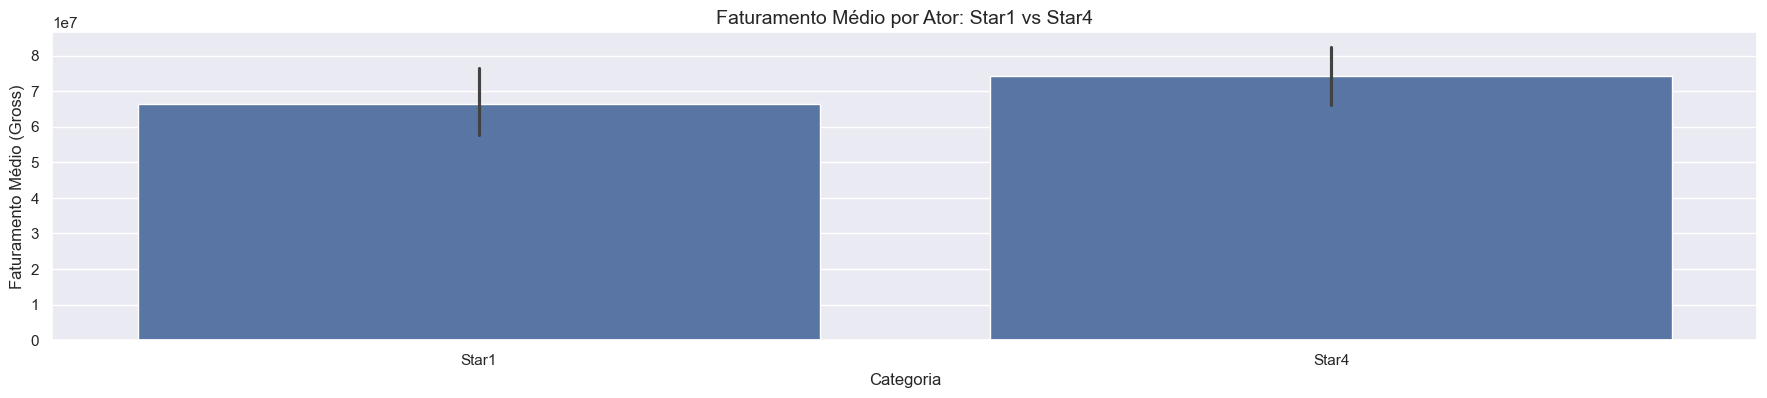

In [45]:
plt.figure(figsize = (22, 4))

star1_gross = df4.groupby("Star1")["Gross"].mean().reset_index()
star1_gross["Categoria"] = "Star1"

star4_gross = df4.groupby("Star4")["Gross"].mean().reset_index()
star4_gross.rename(columns = {"Star4": "Star1"}, inplace=True)
star4_gross["Categoria"] = "Star4"

df_stars = pd.concat([star1_gross, star4_gross], ignore_index = True)

sns.barplot(data = df_stars, x = "Categoria", y = "Gross")
plt.title("Faturamento Médio por Ator: Star1 vs Star4", fontsize = 14)
plt.ylabel("Faturamento Médio (Gross)")
plt.xlabel("Categoria")
plt.show();

**8.** Diretores com múltiplos filmes tendem a ter notas consistentemente boas?

**Verdadeira** Existe uma correlação positiva (0,150) considerada fraca de que filmes com diretores com mais filmes tem notas mais altas.

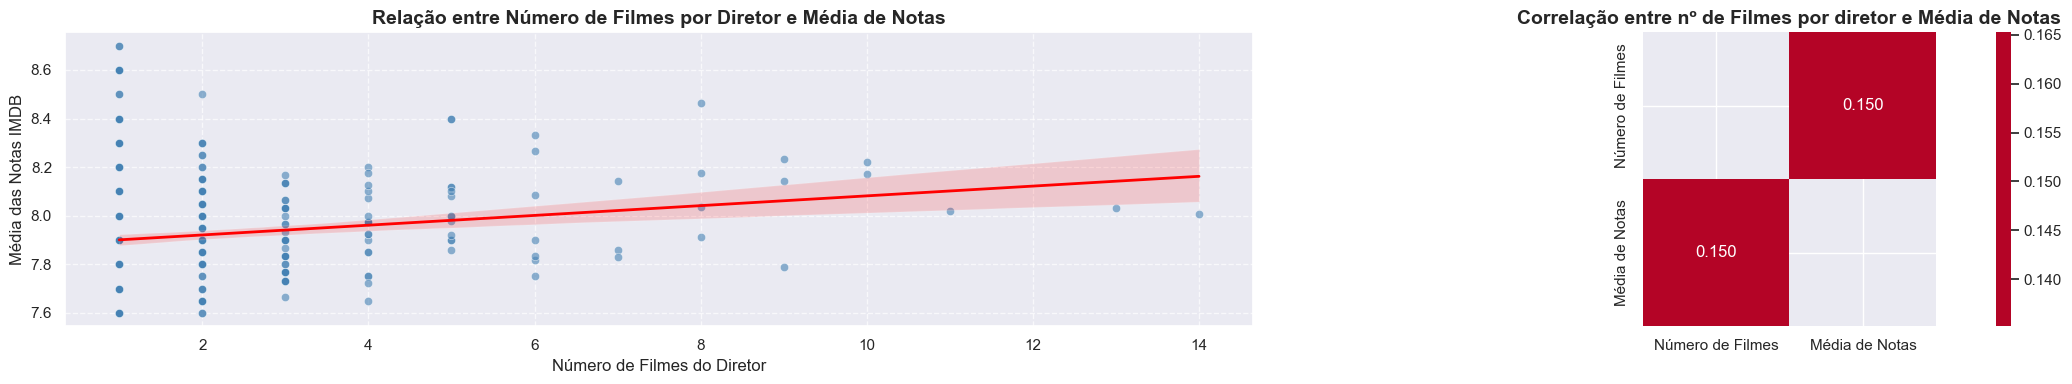

In [46]:
plt.figure(figsize = (22, 4))

df_diretores = df.groupby('Director').agg(
    Num_Filmes = ('IMDB_Rating', 'count'),
    Media_Notas = ('IMDB_Rating', 'mean')
).reset_index()

plt.subplot(1, 2, 1)
sns.scatterplot(data = df_diretores, x = 'Num_Filmes', y = 'Media_Notas', 
                alpha = 0.6, color = 'steelblue')
sns.regplot(data = df_diretores, x = 'Num_Filmes', y = 'Media_Notas', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre Número de Filmes por Diretor e Média de Notas', 
          fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Filmes do Diretor')
plt.ylabel('Média das Notas IMDB')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)
correlacao = df_diretores['Num_Filmes'].corr(df_diretores['Media_Notas'])
correlation_matrix = pd.DataFrame([[1, correlacao], 
                                  [correlacao, 1]],
                                 columns = ['Número de Filmes', 'Média de Notas'], 
                                 index = ['Número de Filmes', 'Média de Notas'])

mask = np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre nº de Filmes por diretor e Média de Notas', 
          fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

**9.** A nota média do IMDB aumentou ao longo dos anos?

**Falsa** A nota média diminuiu ao longo dos anos.

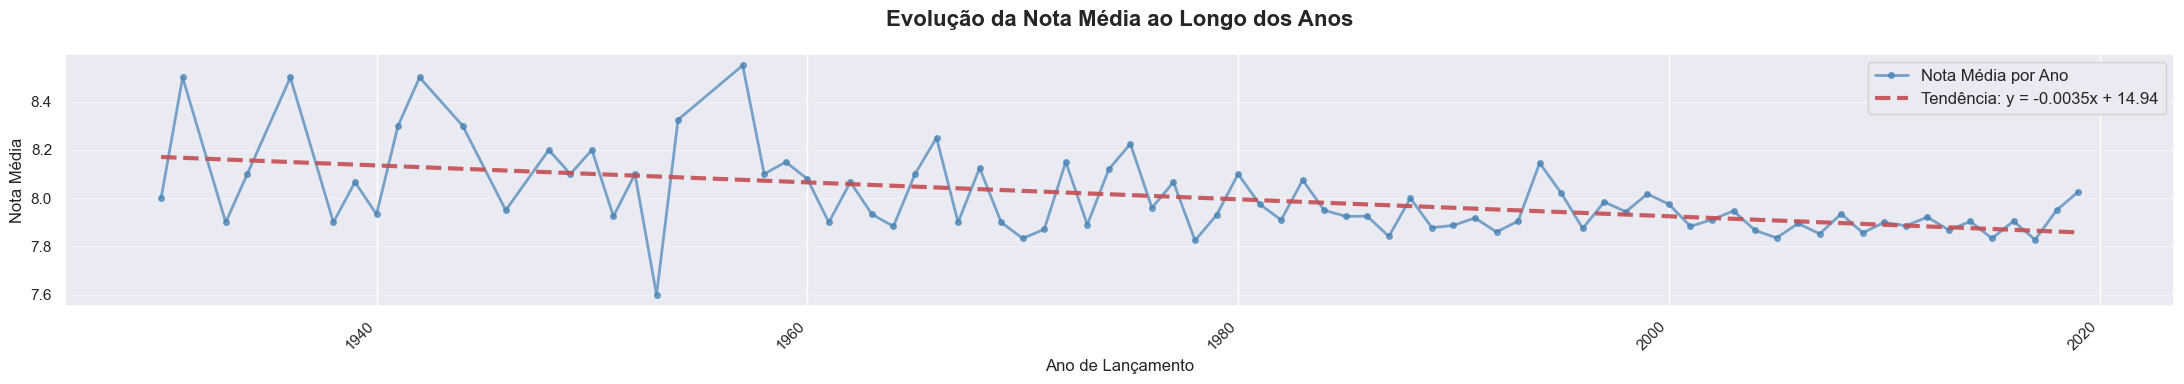

In [47]:
plt.figure(figsize = (22, 4))

media_ano = df4.groupby('Released_Year')['IMDB_Rating'].mean().reset_index()

plt.plot(media_ano['Released_Year'], media_ano['IMDB_Rating'], 
         'o-', alpha = 0.7, linewidth = 2, markersize = 4, 
         color = 'steelblue', label = 'Nota Média por Ano')

z = np.polyfit(media_ano['Released_Year'], media_ano['IMDB_Rating'], 1)
p = np.poly1d(z)
plt.plot(media_ano['Released_Year'], p(media_ano['Released_Year']), 
         "r--", alpha = 0.9, linewidth = 3, 
         label = f'Tendência: y = {z[0]:.4f}x + {z[1]:.2f}')

plt.title('Evolução da Nota Média ao Longo dos Anos', 
          fontsize = 16, fontweight = 'bold', pad = 20)
plt.xlabel('Ano de Lançamento', fontsize = 12)
plt.ylabel('Nota Média', fontsize = 12)
plt.grid(axis = 'y', alpha = 0.3)

plt.xticks(rotation = 45, ha = 'right')
plt.legend(fontsize = 12, loc = 'best')

plt.tight_layout()
plt.show();

**10.** A duração média dos filmes diminuiu com o tempo?

**Falsa** A duração média dos filmes teve um ligeiro aumento ao longo dos anos.

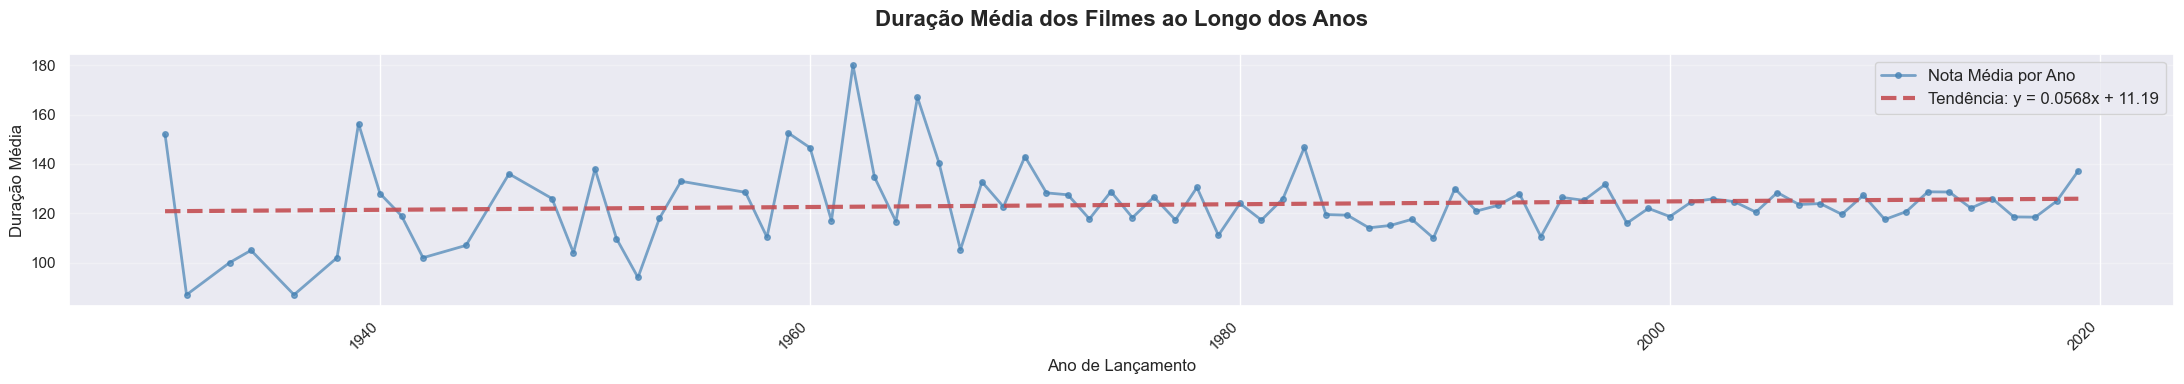

In [48]:
plt.figure(figsize = (22, 4))

media_ano = df4.groupby('Released_Year')['Runtime'].mean().reset_index()

plt.plot(media_ano['Released_Year'], media_ano['Runtime'], 
         'o-', alpha = 0.7, linewidth = 2, markersize = 4, 
         color = 'steelblue', label = 'Nota Média por Ano')

z = np.polyfit(media_ano['Released_Year'], media_ano['Runtime'], 1)
p = np.poly1d(z)
plt.plot(media_ano['Released_Year'], p(media_ano['Released_Year']), 
         "r--", alpha = 0.9, linewidth = 3, 
         label = f'Tendência: y = {z[0]:.4f}x + {z[1]:.2f}')

plt.title('Duração Média dos Filmes ao Longo dos Anos', 
          fontsize = 16, fontweight = 'bold', pad = 20)
plt.xlabel('Ano de Lançamento', fontsize = 12)
plt.ylabel('Duração Média', fontsize = 12)
plt.grid(axis = 'y', alpha = 0.3)

plt.xticks(rotation = 45, ha = 'right')
plt.legend(fontsize = 12, loc = 'best')

plt.tight_layout()
plt.show();

**11.** Filmes com maior número de votos têm maior bilheteria?

**Verdadeira** Filmes com mais votos, ou seja, mais assistidos ou mais populares, tendem a ter maior bilheteria. Está variável possui um correlação moderada de 0,562.

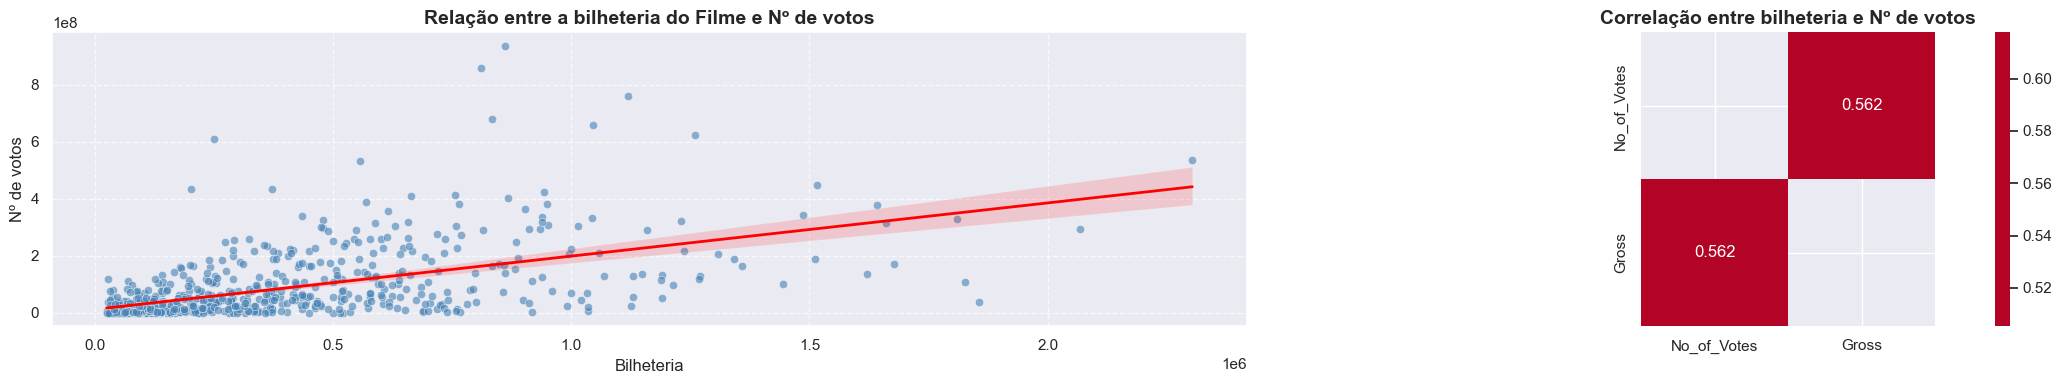

In [49]:
plt.figure(figsize = (22, 4))

plt.subplot(1, 2, 1)

sns.scatterplot(data = df4, x = 'No_of_Votes', y = 'Gross', alpha = 0.6, color = 'steelblue')
sns.regplot(data = df4, x = 'No_of_Votes', y = 'Gross', 
            scatter = False,
            line_kws = {"color": "red", "linewidth": 2})

plt.title('Relação entre a bilheteria do Filme e Nº de votos', fontsize = 14, fontweight = 'bold')
plt.xlabel('Bilheteria')
plt.ylabel('Nº de votos')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.subplot(1, 2, 2)

correlacao_votos = df4['No_of_Votes'].corr(df4['Gross'])
correlation_matrix = pd.DataFrame([[1, correlacao_votos], 
                                  [correlacao_votos, 1]],
                                 columns = ['No_of_Votes', 'Gross'], 
                                 index = ['No_of_Votes', 'Gross'])

mask  =  np.eye(len(correlation_matrix), dtype = bool)

sns.heatmap(correlation_matrix, 
            mask = mask,
            annot = True, 
            cmap = "coolwarm", 
            center = 0, 
            square = True,
            fmt = ".3f",
            cbar = True)

plt.title('Correlação entre bilheteria e Nº de votos', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show();

### 4.5 Análise multivariada

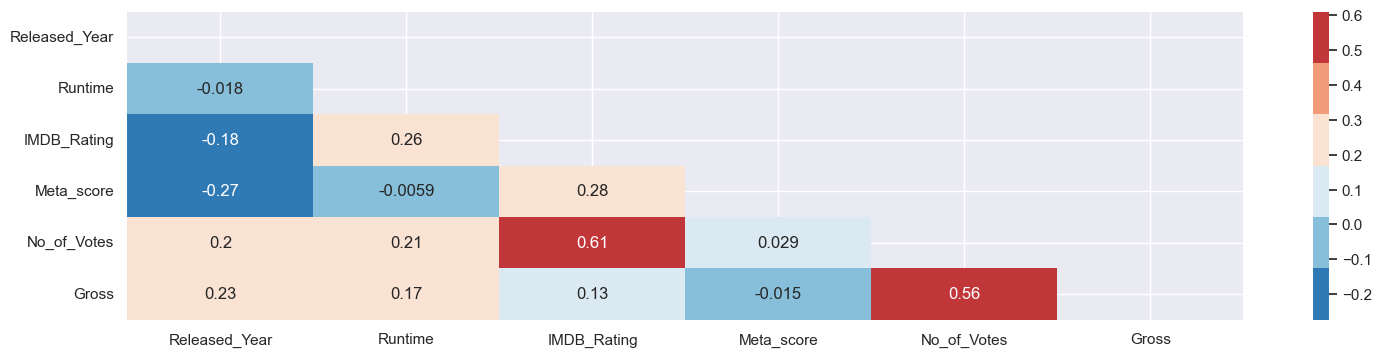

In [50]:
plt.figure(figsize = (18, 4))

numeric_df = df4.select_dtypes(include = [np.number])
correlation = numeric_df.corr(method = 'pearson')
mask = np.triu(np.ones_like(correlation))
cmap = sns.color_palette('RdBu_r')
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, cmap = cmap, mask = mask, annot = True);

* É importante notar que busca-se uma forte relação entre as variáveis independentes e a variável dependente. Por outro lado, é desejável que haja uma baixa relação entre as variáveis independentes, a fim de evitar a multicolinearidade.
* A correlação mostra que o fator mais ligado ao faturamento é o número de votos (0.56), seguido pelo ano de lançamento (0.23). Já as avaliações (IMDb e Meta_score) não têm relação forte com o faturamento, mas estão moderadamente correlacionadas entre si (0.28). Um ponto interessante é que filmes mais novos tendem a ter notas menores no IMDb (-0.18) e no Metascore (-0.27).
Em contrapartida, a duração do filme não tem impacto relevante em nenhum dos indicadores.

<Figure size 1800x400 with 0 Axes>

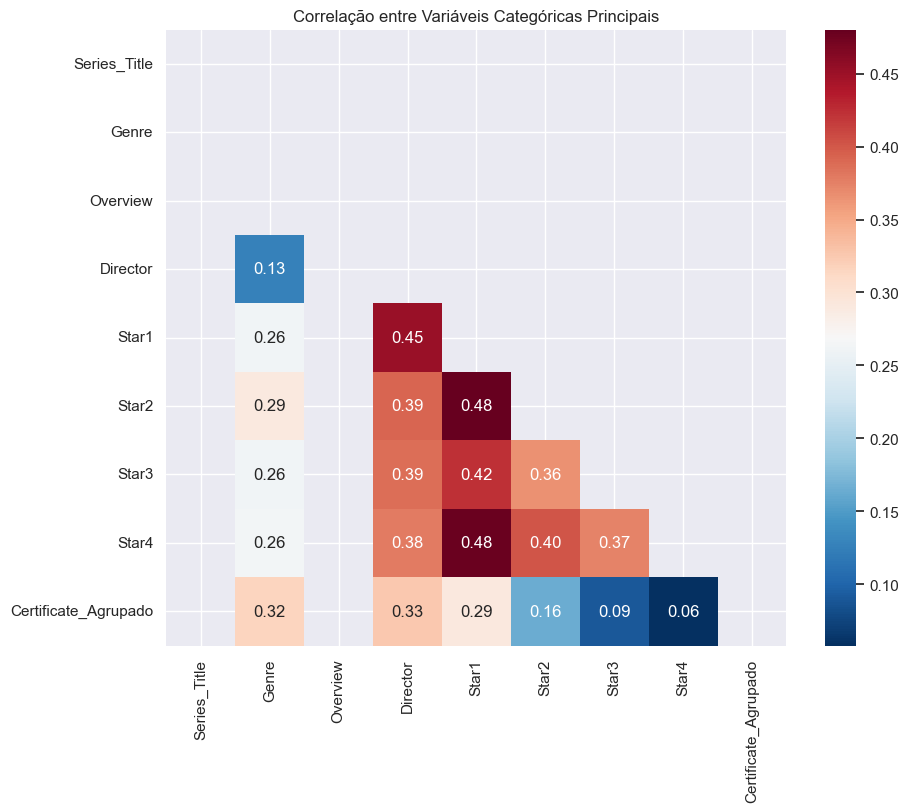

In [51]:
plt.figure(figsize = (18, 4))

variaveis_selecionadas = ['Series_Title', 'Genre', 'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'Certificate_Agrupado']
correlacao_categorica = df4[variaveis_selecionadas]

n_variaveis = len(variaveis_selecionadas)
matriz_correlacao = np.zeros((n_variaveis, n_variaveis))

for i in range(n_variaveis):
    for j in range(n_variaveis):
        matriz_correlacao[i, j] = cramer_v(correlacao_categorica[variaveis_selecionadas[i]], 
                                          correlacao_categorica[variaveis_selecionadas[j]])

# Criar DataFrame
d = pd.DataFrame(matriz_correlacao, 
                index = variaveis_selecionadas, 
                columns = variaveis_selecionadas)

# Heatmap
plt.figure(figsize = (10, 8))
mask = np.triu(np.ones_like(d, dtype = bool))
sns.heatmap(d, annot = True, mask = mask, cmap = 'RdBu_r', fmt = ".2f")
plt.title('Correlação entre Variáveis Categóricas Principais')
plt.show();

 * Interpretação do V de Cramér:

    0.00 - Nenhuma associação
 
    0.01 - 0.09	Associação muito fraca
 
    0.10 - 0.19	Associação fraca
 
    0.20 - 0.29	Associação moderada
 
    0.30 - 0.39	Associação relativamente forte
 
    0.40 - 0.49	Associação forte
 
    0.50 - 1.00	Associação muito forte

* As baixas correlações indicam que as variáveis categóricas analisadas são bastante independentes, o que é positivo para análises multivariadas, pois reduz problemas de multicolinearidade.
* Destaca-se que as variáveis relacionadas ao elenco (Star1, Star2, Star3, Star4) mostram alguma interdependência, sugerindo que certos atores tendem a trabalhar juntos frequentemente.
* As variáveis 'Series_Title' e 'Overview', como esperado, mostram correlações mínimas com as demais, uma vez que são elementos únicos para cada produção de filmes.

### 4.6 Variabilidade
* Variáveis com pouca variância não ajudam na construção de modelos mais robustos, pois não oferecem diferenciação significativa entre os dados.

In [52]:
analise_variancia(df4)

Variância das variáveis numéricas:
Gross           13,240,791,259,443,462
No_of_Votes            120,027,714,175
Runtime                            671
Released_Year                      346
Meta_score                         154
IMDB_Rating                 0.08347943

Número de valores únicos nas variáveis categóricas:
Series_Title            712
Certificate              12
Genre                   172
Overview                712
Director                402
Star1                   471
Star2                   597
Star3                   625
Star4                   669
Certificate_Agrupado      6
dtype: int64


**Variáveis Numéricas:**
- **Gross**: Variância altíssima (13 trilhões) → Grande potencial preditivo;
- **No_of_Votes**: Alta variância → Boa capacidade discriminatória;
- **IMDB_Rating**: Variância muito baixa (0.08) → Pouca variabilidade, notas consistentes.

**Variáveis Categóricas:**
- **Series_Title/Overview**: Valores únicos → Irrelevantes para modelo;
- **Atores/Diretor**: Alta diversidade → Podem capturar padrões de popularidade;
- **Gênero/Certificate_Agrupado**: Diversidade controlada → Boas também.

### 4.7 Resumo das variáveis mais relevantes para faturamento

<span style = "color:green">1. Número de Votos (No_of_Votes) - Correlação FORTE (0.562)</span>

Variável mais impactante. Um alto número de votos no IMDB indica um grande volume de audiência, que está diretamente ligado ao sucesso de bilheteria. Reflete popularidade e engajamento do público.

<span style = "color:green">2. Gênero (Genre) - Tendência FORTE (Análise Qualitativa)</span>

Filmes dos gêneros Família, Ação e Aventura (especialmente quando combinados com Comédia ou Ficção Científica) têm a maior mediana de arrecadação.

<span style = "color:green">3. Diretor (Director) - Tendência FORTE (Análise Qualitativa)</span>

Diretores de grande renome e que comandam franquias, como Antony Russo e Gareth Edwards, têm uma tendência clara de gerar filmes com arrecadação muito alta.

<span style = "color:green">4. Elenco Principal (Star1) - Tendência FORTE (Análise Qualitativa)</span>

A presença de atores como Daisy Ridley e Sam Worthington (atuaram  em filmes gigantes como Star Wars e Avatar), está fortemente associada a uma maior mediana de faturamento.

<span style = "color:green">5. Classificação Indicativa (Certificate_Agrupado) - Tendência Moderada</span>

Filmes com classificação Livre (L), 12+, e 18+ tendem a performar melhor. Isso permite atingir um público amplo (Livre e 12+) ou um público adulto fiel para certos gêneros (18+).

<span style = "color:green">6. Ano de Lançamento (Released_Year) - Correlação FRACA (0.235)</span>

Existe uma leve tendência de filmes mais novos arrecadarem mais, mas a correlação é fraca.

<span style = "color:green">7. Duração (Runtime) - Correlação FRACA (0.169)</span>

Filmes mais longos podem ter uma arrecadação ligeiramente maior, mas não é um fator decisivo.

<span style = "color:green">8. Avaliação do IMDB (IMDB_Rating) - Correlação FRACA (0.132)</span>

A nota do público tem uma influência muito pequena e direta na bilheteria.

<span style = "color:green">9. Meta Score (Meta_score) - Correlação INEXISTENTE (-0.015)</span>

A crítica especializada praticamente não tem relação com o sucesso financeiro de um filme.

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados
##### Neste tópico, os dados poderão ser transformados, ou seja, as variáveis categóricas poderão ser convertidas em números, as variáveis numéricas poderão ser reescalados, em outras palavras, colocadas em uma escala comum. Também neste passo, serão testados os algoritmos de machine learning para avaliação.

### 5.1 Copia dos dados

In [53]:
df5 = df4.copy()

In [54]:
# Transpondo os dados da coluna Certificate_Agrupado
# Definir a ordem das categorias para garantir as colunas na ordem desejada
categorias_ordenadas = ['10+', '12+', '13+', '17+', '18+', 'Livre']

onehot_encoder = OneHotEncoder(categories = [categorias_ordenadas], # Ordem específica
                               drop = 'first', # Opcional: remove uma coluna para evitar multicolinearidade
                               sparse_output = False,
                               handle_unknown = 'ignore') # Importante para novos dados

certificate_encoded = onehot_encoder.fit_transform(df5[['Certificate_Agrupado']])

# Salvando as transformações
pickle.dump(onehot_encoder, open('../transformacoes/cert_encoder.pkl', 'wb'))

# Criando um dataframe com os nomes específicos
nomes_colunas = onehot_encoder.get_feature_names_out(['Certificate_Agrupado'])

# Criar DataFrame
certificate_df = pd.DataFrame(certificate_encoded, 
                             columns = nomes_colunas, 
                             index = df5.index)

df5 = pd.concat([df5, certificate_df], axis = 1)

In [55]:
# Tratando a coluna 'Genre'
# Instanciando o MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Separando os gêneros, exemplo: (transformar "Crime, Drama" em ["Crime", "Drama"])
generos_split = df5['Genre'].str.split(', ')

# Aplicando o MultiLabelBinarizer
genre_encoded = mlb.fit_transform(generos_split)

# Salvando as transformações
pickle.dump(mlb, open('../transformacoes/mlb_genre.pkl', 'wb'))

# Obtendo os nomes das novas colunas
nomes_colunas_genre = [f'Genre_{genero}' for genero in mlb.classes_]

# Criando um dataframe com as novas colunas
genre_df = pd.DataFrame(genre_encoded, 
                       columns = nomes_colunas_genre, 
                       index = df5.index)

# Concatenando os dataframes
df5 = pd.concat([df5, genre_df], axis = 1)

### 5.2 Separar os dados em treino e teste

In [56]:
# Essas colunas não estariam disponiveis para produção: 'No_of_Votes', 'Gross', 'Meta_score'
# Essas colunas tem pouca variabilidade, pois são valores únicos: 'Series_Title', 'Overview'

colunas_numericas = ['Released_Year', 'Runtime', 'Certificate_Agrupado_12+',
                     'Certificate_Agrupado_13+', 'Certificate_Agrupado_17+', 
                     'Certificate_Agrupado_18+', 'Certificate_Agrupado_Livre',
                     'Genre_Action', 'Genre_Adventure', 'Genre_Animation',
                     'Genre_Biography', 'Genre_Comedy', 'Genre_Crime',
                     'Genre_Drama', 'Genre_Family', 'Genre_Fantasy', 'Genre_Film-Noir',
                     'Genre_History', 'Genre_Horror', 'Genre_Music', 'Genre_Musical',
                     'Genre_Mystery', 'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Sport',
                     'Genre_Thriller', 'Genre_War', 'Genre_Western']

colunas_categoricas = ['Director', 'Star1', 'Star2', 'Star3', 'Star4'] # Muitas categorias
variavel_dependente = 'IMDB_Rating'

variaveis_independentes = colunas_numericas + colunas_categoricas
x = df5[variaveis_independentes]
y = df5[variavel_dependente].copy()

x_treino, x_teste, y_treino, y_teste = ms.train_test_split(x, y, test_size = 0.2, random_state = 42)

In [57]:
x_treino.shape, x_teste.shape, y_treino.shape, y_teste.shape

((569, 33), (143, 33), (569,), (143,))

### 5.3 Pipeline dos dados

REGRAS PARA ESCOLHA DO TIPO DE TRANSFORMAÇÃO:

1. **Distribuição normal** e <span style = "color:green">não possui outliers</span> -> <span style = "color:yellow">Padronização (StandardScaler)</span>
   - Este tipo de transformação é indicado para variáveis que seguem uma distribuição normal.
   - Verificar na análise univariada quais variáveis apresentam distribuição normal.
   - **Resultado:** média 0 e desvio padrão 1.

2. **Distribuição não normal** e <span style = "color:green">não possui outliers</span> -> <span style = "color:yellow">Normalização (MinMaxScaler)</span>
   - Indicada para variáveis com distribuição não normal.
   - Transforma os dados para um intervalo entre 0 e 1.
   - **Quando usar:** quando os dados precisam ser colocados em uma escala limitada.

3. **Distribuição normal ou não normal** e <span style = "color:pink">possui outliers</span> -> <span style = "color:yellow">Normalização (RobustScaler)</span>
   - Utiliza os quartis para normalizar os dados, o que torna a transformação robusta a outliers.
   - **Quando usar:** útil quando há presença de outliers que impactam os dados, mantendo a mediana centralizada.

4. **Distribuição não normal** e com valores positivos -> <span style = "color:yellow">Transformação Logarítmica</span>
   - Aplica-se a variáveis com assimetria positiva, yellowuzindo a diferença entre valores altos e baixos.
   - **Quando usar:** indicada quando a relação entre variáveis é multiplicativa ou quando os valores possuem grandes diferenças de magnitude.
   - **Resultado:** distribuições com grande assimetria positiva se tornam mais simétricas.

5. **Distribuição não normal** e contém valores positivos -> <span style = "color:yellow">Transformação Box-Cox</span>
   - Usada para estabilizar a variância e transformar a distribuição em algo próximo ao normal.
   - **Quando usar:** aplicável em dados com distribuição não normal e que atendem ao critério de positividade.
   - **Resultado:** pode corrigir tanto assimetrias positivas quanto negativas, ajustando os dados para uma distribuição próxima da normal.

In [58]:
# Criar dicionário de frequências
freq_dict = {}
x_treino_encoded = x_treino.copy()
for col in colunas_categoricas:
    freq = x_treino[col].value_counts(normalize=True)
    freq_dict[col] = freq.to_dict()  # salvar o mapeamento
    x_treino_encoded[col + '_freq'] = x_treino[col].map(freq).fillna(0)

# Salvar o dicionário de frequências
pickle.dump(freq_dict, open('../transformacoes/freq_dict.pkl','wb'))

# Aplicar a mesma codificação no teste
x_teste_encoded = x_teste.copy()
for col in colunas_categoricas:
    x_teste_encoded[col + '_freq'] = x_teste[col].map(freq_dict[col]).fillna(0)

# Definir colunas finais (numéricas + frequency encoded)
colunas_finais = colunas_numericas + [col + '_freq' for col in colunas_categoricas]

# Pipeline apenas para passthrough (já que tudo está pré-processado)
preprocessor_simples = ColumnTransformer(transformers = [('passthrough', 'passthrough', colunas_finais)],
                                         remainder = 'drop')

In [59]:
# Aplicar frequency encoding nas demais categorias 'Director', 'Star1', 'Star2', 'Star3', 'Star4'
def aplicar_frequency_encoding_manual(df, colunas_categoricas, freq_dict = None):
    df = df.copy()
    # Se não houver dicionário de frequências, calcular e retornar
    if freq_dict is None:
        freq_dict = {}
        for col in colunas_categoricas:
            freq = df[col].value_counts(normalize = True)
            df[col + '_freq'] = df[col].map(freq).fillna(0)
            freq_dict[col] = freq.to_dict()
        return df, freq_dict
    else:
        # Se freq_dict já existe (por ex., novos dados), apenas aplicar
        for col in colunas_categoricas:
            df[col + '_freq'] = df[col].map(freq_dict[col]).fillna(0)
        return df

# Salvando as transformações
pickle.dump(freq_dict, open('../transformacoes/freq_dict.pkl', 'wb'))

# Aplicar frequency encoding manualmente primeiro
x_treino_encoded, freq_dict = aplicar_frequency_encoding_manual(x_treino, colunas_categoricas)
x_teste_encoded = aplicar_frequency_encoding_manual(x_teste, colunas_categoricas, freq_dict = freq_dict)

# Definir colunas finais (numéricas + frequency encoded)
colunas_finais = colunas_numericas + [col + '_freq' for col in colunas_categoricas]

# Selecionar apenas as colunas processadas
x_treino_final = x_treino_encoded[colunas_finais]
x_teste_final = x_teste_encoded[colunas_finais]

# Pipeline apenas para passthrough (já que tudo está pré-processado)
preprocessor_simples = ColumnTransformer(transformers = [('passthrough', 'passthrough', colunas_finais)],
                                         remainder = 'drop')

In [60]:
x_treino_final.head(3)

,Released_Year,Runtime,Certificate_Agrupado_12+,Certificate_Agrupado_13+,Certificate_Agrupado_17+,Certificate_Agrupado_18+,Certificate_Agrupado_Livre,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Film-Noir,Genre_History,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western,Director_freq,Star1_freq,Star2_freq,Star3_freq,Star4_freq
375,1946,102,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0.015817,0.005272,0.001757,0.003515,0.001757
344,2006,109,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.007030,0.001757,0.003515,0.005272,0.005272
526,2007,122,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.001757,0.001757,0.005272,0.001757,0.003515


* Na Análise Exploratória de Dados (EDA), observamos que a maioria das variáveis apresentava uma distribuição não normal e outliers. Diante disso, a melhor opção de pré-processamento foi o RobustScaler, que garante que os dados sejam escalados de forma eficaz sem serem distorcidos pelos valores extremos.
* Para as variáveis categóricas de alta cardinalidade (Director: 402 valores, Star1: 471 valores e assim por diante), foi avaliado três opções: OneHot Encoding, que geraria 2460+ colunas e causaria overfitting, Target Encoding, que introduziria data leakage e Frequency Encoding, que preservaria a informação de popularidade mantendo apenas 5 features. Optou-s por essa última transformação por reduzir a dimensionalidade, evitar overfitting e capturar intuitivamente que diretores/atores.

### 5.4 Treinar o modelo baseline

TIPOS DE MÉTRICAS:

1. **RMSE** (Root Mean Squared Error): Ideal para <span style = "color:yellow">medir a performance de modelos de machine learning</span>, pois penaliza erros maiores mais fortemente. Valores menores indicam melhor desempenho do modelo.
    - Exemplo: Em um modelo de previsão de preços de imóveis, um RMSE de 25.000 significa que, em média, as previsões do modelo diferem do valor real em aproximadamente +/- 25.000.

2. **MAE** (Mean Absolute Error): Mede o erro médio absoluto, sendo <span style = "color:yellow">útil para entender a precisão geral do modelo</span>. Menor MAE significa previsões mais precisas e é robusto a outliers.
    - Exemplo: Em um modelo de previsão de preços de imóveis, um MAE de 25.000 significa que, em média, as previsões do modelo diferem do valor real em aproximadamente +/- 25.000.

3. **MAPE** (Mean Absolute Percentage Error): Normalmente <span style = "color:yellow">usado na divulgação de resultados</span>, pois apresenta o erro em termos percentuais. É útil para entender a precisão relativa das previsões. Contudo, pode ser sensível a valores reais muito pequenos.
    - Exemplo: Se um modelo prevê a demanda semanal de um produto e obtém um MAPE de 10%, isso significa que, em média, o erro das previsões representa 10% do valor real. Ou seja, se a demanda real for 1.000 unidades, a previsão pode variar em torno de 100 unidades para mais ou para menos.

4. **R²** (R-Squared): Indica a proporção da <span style = "color:yellow">variabilidade dos dados explicada pelo modelo</span>. Valores próximos de 1 significam um bom ajuste, enquanto valores negativos indicam um modelo ruim.
    - Exemplo: Em um modelo de regressão que prevê o consumo de energia com base na temperatura, um R² de 0.85 indica que 85% da variação do consumo pode ser explicada pelo modelo.

In [61]:
pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor_simples), 
                                    ('modelo', DummyRegressor())])

pipeline_modelo

,steps,"[('preprocessor', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('passthrough', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 5.5 Treinar com vários modelos

In [62]:
modelos = [DummyRegressor(),
           LinearRegression(),
           LassoCV(),
           RidgeCV(),
           RandomForestRegressor(random_state = 42),
           GradientBoostingRegressor(random_state = 42)]

pipeline_modelo = Pipeline([('modelo', DummyRegressor())])

# Configurando a busca bayesiana (BayesSearchCV)
grid_search_modelo = GridSearchCV(pipeline_modelo,
                                  param_grid = {'modelo': modelos},
                                  cv = 5, # Validação cruzada
                                  n_jobs = -1, # Usar todos os núcleos
                                  scoring = 'neg_root_mean_squared_error') # Métrica de avaliação rmse

grid_search_modelo.fit(x_treino_final, y_treino)

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'modelo': [DummyRegressor(), LinearRegression(), ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


### 5.6 Modelo escolhido

In [63]:
grid_search_modelo.best_estimator_

,steps,"[('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0


In [64]:
df_resultado = pd.DataFrame(grid_search_modelo.cv_results_).set_index('rank_test_score').sort_index()
df_resultado.loc[:, ~df_resultado.columns.str.contains('split|time')]

,param_modelo,params,mean_test_score,std_test_score
rank_test_score,,,,
1,RandomForestRegressor(random_state=42),{'modelo': RandomForestRegressor(random_state=...,-0.273928,0.015599
2,LassoCV(),{'modelo': LassoCV()},-0.274912,0.022747
3,RidgeCV(),{'modelo': RidgeCV()},-0.275652,0.020190
4,LinearRegression(),{'modelo': LinearRegression()},-0.275961,0.019549
5,GradientBoostingRegressor(random_state=42),{'modelo': GradientBoostingRegressor(random_st...,-0.279301,0.019921
6,DummyRegressor(),{'modelo': DummyRegressor()},-0.289004,0.019520


* O RandomForestRegressor foi selecionado como o melhor modelo, alcançando um RMSE de 0.273 na validação cruzada. No entanto, este resultado apresenta desempenho abaixo do esperado para a tarefa de previsão de notas do IMDB.

### 5.7 Treinar o modelo escolhido com os hiperparâmetros

In [65]:
pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor_simples),
                                    ('modelo', RandomForestRegressor(random_state = 42))])

params = {'modelo__n_estimators': [100, 200, 300],
          'modelo__max_depth': [None, 10, 20, 30],
          'modelo__min_samples_split': [2, 5, 10],
          'modelo__min_samples_leaf': [1, 2, 4],
          'modelo__max_features': ['sqrt', 'log2', None]}

grid_modelo = GridSearchCV(pipeline_modelo,
                           param_grid = params,
                           cv = 5, # Validação cruzada
                           n_jobs = -1, # Usar todos os núcleos
                           scoring = 'neg_root_mean_squared_error') # Métrica de avaliação rmse

grid_modelo.fit(x_treino_final, y_treino)

#Salvando o modelo treinado em Pickle
pickle.dump(grid_modelo, open('../modelo/modelo_treinado.pkl', 'wb'))

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'modelo__max_depth': [None, 10, ...], 'modelo__max_features': ['sqrt', 'log2', ...], 'modelo__min_samples_leaf': [1, 2, ...], 'modelo__min_samples_split': [2, 5, ...], ...}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('passthrough', ...)]"


In [66]:
df_resultado = pd.DataFrame(grid_modelo.cv_results_).set_index('rank_test_score').sort_index()
df_resultado.loc[:, ~df_resultado.columns.str.contains('split|time')].head()

,param_modelo__max_depth,param_modelo__max_features,param_modelo__min_samples_leaf,param_modelo__n_estimators,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,10,log2,1,200,"{'modelo__max_depth': 10, 'modelo__max_feature...",-0.267743,0.018712
1,10,sqrt,1,200,"{'modelo__max_depth': 10, 'modelo__max_feature...",-0.267743,0.018712
3,10,log2,2,100,"{'modelo__max_depth': 10, 'modelo__max_feature...",-0.267860,0.018644
3,10,sqrt,2,100,"{'modelo__max_depth': 10, 'modelo__max_feature...",-0.267860,0.018644
5,10,sqrt,1,300,"{'modelo__max_depth': 10, 'modelo__max_feature...",-0.267898,0.018494


* A otimização de hiperparâmetros proporcionou uma melhoria de 2.6% no RMSE, reduzindo o erro médio de previsão de 0.274 para 0.267 pontos. Este ganho incremental, indica que as limitações fundamentais de performance estão mais relacionadas à natureza dos dados e ao poder preditivo das colunas disponíveis do que à configuração dos hiperparâmetros. A modesta melhoria sugere que o modelo já operava próximo de seu potencial máximo com o conjunto de features atual, destacando a oportunidade para avanços maiores através da exploração de novas variáveis.

### 5.8 Performance final do modelo

In [67]:
pipeline_modelo = grid_modelo.best_estimator_
y_pred = pipeline_modelo.predict(x_teste_final)
ml_error(y_teste, y_pred, desvpad = True)

,mae,mape,rmse,r2
0,0.22 +/- 0.18,2.73% +/- 0.02%,0.28 +/- 0.20,0.04


# 6. Conclusão

* O modelo de regressão para prever as notas apresentou resultados mistos. O Mean Absolute Error (MAE) de 0,22 ± 0,18 indica que, em média, as previsões do modelo divergem apenas 0,22 pontos da nota real, o que é considerado excelente em uma escala de 0 a 10. Da mesma forma, o Mean Absolute Percentage Error (MAPE) de 2,73% ± 0,02% confirma a alta precisão, com erro percentual médio abaixo de 3%, valor geralmente classificado como muito bom em projetos de previsão. O Root Mean Square Error (RMSE) de 0,28 ± 0,20 também ajuda na qualidade das previsões, mostrando que erros grandes são raros e que a maioria das previsões está concentrada próxima aos valores reais. No entanto, o coeficiente de determinação R² de 0,04 revela uma limitação significativa: o modelo explica apenas 4% da variabilidade total das notas do IMDB. Isso sugere que, embora as previsões sejam pontualmente precisas, o modelo não captura adequadamente os fatores subjacentes que influenciam as variações nas avaliações.
Essa disparidade entre erros absolutos baixos e R² reduzido pode indicar que o modelo é capaz de fazer previsões consistentes para certos padrões, mas falha em generalizar para toda a complexidade dos dados. Possíveis causas incluem a necessidade de variáveis mais informativas, também seria importante investigar possíveis problemas como underfitting ou vazamento de dados durante o treinamento.

### <span style = "color:green">2. Responda também às seguintes perguntas:</span>

### Escolha por faixa etária e diretor preferido

In [68]:
filtros_Certificate = ['G', 'U', 'Passed', 'Approved']
filtros_Director = ['Steven Spielberg', 'Martin Scorsese', 'Alfred Hitchcock']

df_filtrado_1 = df1[
    (df1['Certificate'].isin(filtros_Certificate)) &
    (df1['Genre'] == 'Drama') &
    (df1['Director'].isin(filtros_Director))
]

df_filtrado_1

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
466,The Color Purple,1985,U,154,Drama,7.8,A black Southern woman struggles to find her i...,78.0,Steven Spielberg,Danny Glover,Whoopi Goldberg,Oprah Winfrey,Margaret Avery,78321,98467863.0


### <span style = "color:green">a. Qual filme você recomendaria para uma pessoa que você não conhece?</span>
### Resposta: Recomendo o filme The Color Purple, com nota 7.8, do gênero Drama, dirigido por Steven Spielberg e estrelado por Danny Glover, Whoopi Goldberg, Oprah Winfrey e Margaret Avery.

### <span style = "color:green">b. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?</span>
### Resposta: Para avaliar a expectativa de faturamento antes de um filme ser lançado, devemos ignorar métricas resultantes (como número de votos) e focar nos elementos do próprio projeto. A análise mostra que filmes dos gêneros Família, Ação e Aventura (especialmente combinados com Comédia ou Ficção Científica) tendem a ter a maior mediana de arrecadação. Diretores como Antony Russo e Gareth Edwards estão no topo da lista porque seu envolvimento gera imediatamente uma expectativa de grande espetáculo e sucesso comercial. A presença de atores com histórico de bilheteria, como Daisy Ridley ou Sam Worthington tendem a garantirem notoriedade à produção e ajudam a vender o filme e por fim, filmes com classificação Livre e 12+, que permitem um público amplo e familiar, essencial para vender milhões de ingressos, já a classificação 18+ também é relevante para gêneros específicos de alto orçamento que targetam adultos.

### <span style = "color:green">c. Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?</span>
### Resposta: No projeto, a coluna Overview foi removida do pré-processamento, pois cada filme possui uma descrição única e pouco padronizada, o que dificultaria encontrar padrões consistentes para inferir o gênero. No entanto, seria possível posteriormente explorar essas descrições para extrair informações adicionais, como sentimentos, temas ou palavras-chave que pudessem complementar a análise de gênero ou de popularidade do filme.

### <span style = "color:green">3. Explique como você faria a previsão da nota do imdb a partir dos dados:</span>
### Resposta: Usaria os dados do filme (ano, certificado, duração, gênero, diretor e atores), aplicaria as mesmas transformações usadas no treino e enviaria ao modelo treinado, que retornaria a previsão da nota do IMDb. A previsão poderia ser apresentada junto aos dados originais em um dataframe.

### <span style = "color:green">a. Quais variáveis e/ou suas transformações você utilizou e por quê?</span>
### Resposta: Foram utilizadas as variáveis 'Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'IMDB_Rating', 'Director', 'Star1', 'Star2', 'Star3', 'Star4'. As variáveis 'No_of_Votes', 'Gross' e 'Meta_score' não foram utilizadas, pois não estariam disponíveis em um cenário de produção. As colunas 'Series_Title' e 'Overview' foram removidas devido à baixa variabilidade, contribuindo pouco para a performance do modelo. Para as variáveis numéricas, utilizei RobustScaler, devido à sua robustez frente a outliers. Para as variáveis categóricas, apliquei três tipos de transformações: OneHotEncoder na coluna 'Certificate', por possuir poucas categorias, MultiLabelBinarizer na coluna 'Genre', para lidar com múltiplos gêneros por filme e não aumentar demais a quantidade de colunas e por fim, Frequency Encoding nas colunas 'Director', 'Star1', 'Star2', 'Star3' e 'Star4', pois existem muitas categorias. Obs.: Testei com OneHotEncoder nestas 4 últimas colunas e o dataset aumentou para mais de 2400 colunas!.

### <span style = "color:green">b. Qual tipo de problema estamos resolvendo (regressão, classificação)?</span>
### Resposta: Estamos resolvendo um problema de regressão, pois o objetivo é prever uma variável numérica contínua, no caso, a nota do filme no IMDB.

### <span style = "color:green">c. Qual modelo melhor se aproxima dos dados e quais seus prós e contras?</span>
### Resposta: O modelo que melhor se aproxima dos dados foi o RandomForestRegressor. Escolhi este modelo pois ele é capaz de capturar relações não lineares entre variáveis, é um algoritmo basseado em árvore então é robusto a outliers e variáveis irrelevantes e por último não exige muita pré-processamento complexo. Contudo, pode ser computacionalmente pesado para grandes conjuntos de dados, apesar da otimização de hiperparâmetros, o ganho foi bem modesto, indicando que as limitações vêm mais da natureza dos dados do que da configuração do modelo.

### <span style = "color:green">d. Qual medida de performance do modelo foi escolhida e por quê?</span>
### Resposta: Escolhi a métrica RMSE (Root Mean Squared Error), pois ela penaliza mais fortemente erros grandes, sendo adequada para problemas de regressão. Além disso, o RMSE mantém a mesma unidade da variável target (IMDB_Rating), facilitando a interpretação do erro médio das previsões em termos reais.

### <span style = "color:green">4. Supondo um filme com as seguintes características, qual seria a nota do IMDB?</span>
### Reposta: 8.0

In [69]:
dados = pd.DataFrame({'Series_Title': ['The Shawshank Redemption'],
                      'Released_Year': ['1994'],
                      'Certificate': ['A'],
                      'Runtime': ['142 min'],
                      'Genre': ['Drama'],
                      'Overview': ['Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.'],
                      'Meta_score':[80.0],
                      'Director': ['Frank Darabont'],
                      'Star1': ['Tim Robbins'],
                      'Star2': ['Morgan Freeman'],
                      'Star3': ['Bob Gunton'],
                      'Star4': ['William Sadler'],
                      'No_of_Votes':[2343110],
                      'Gross': ['28,341,469']})

In [70]:
import pickle
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer

modelo_carregado = pickle.load(open('../modelo/modelo_treinado.pkl', 'rb'))
cert_encoder = pickle.load(open('../transformacoes/cert_encoder.pkl', 'rb'))
mlb_genre = pickle.load(open('../transformacoes/mlb_genre.pkl', 'rb'))
freq_dict = pickle.load(open('../transformacoes/freq_dict.pkl', 'rb'))

colunas_categoricas = ['Director', 'Star1', 'Star2', 'Star3', 'Star4']

def limpeza(df):
    df = df.copy()
    df['Released_Year'] = df['Released_Year'].astype(int)
    df['Runtime'] = df['Runtime'].astype(str).str.replace(' min', '', regex=False).astype(int)
    df['Gross'] = (df['Gross'].astype(str).str.replace(',', '', regex=False)
                              .str.replace('.0','', regex=False))
    df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce').astype('Int64')

    rating_mapping = {'G':'Livre','PG':'10+','PG-13':'13+','R':'17+','NC-17':'18+',
                      'U':'Livre','UA':'12+','A':'18+','TV-PG':'10+','Passed':'Livre',
                      'Approved':'Livre','GP':'10+','U/A':'12+'}
    df['Certificate_Agrupado'] = df['Certificate'].map(rating_mapping)
    df = df.drop(['No_of_Votes','Gross','Meta_score'], axis=1, errors='ignore')
    return df

def ajuste_coluna_certificate(df):
    certificate_encoded = cert_encoder.transform(df[['Certificate_Agrupado']])
    nomes_colunas = cert_encoder.get_feature_names_out(['Certificate_Agrupado'])
    certificate_df = pd.DataFrame(certificate_encoded, columns=nomes_colunas, index=df.index)
    df = pd.concat([df, certificate_df], axis=1)
    return df

def ajuste_coluna_genre(df):
    generos_split = df['Genre'].fillna('').str.split(', ')
    genre_encoded = mlb_genre.transform(generos_split)
    nomes_colunas_genre = [f'Genre_{g}' for g in mlb_genre.classes_]
    genre_df = pd.DataFrame(genre_encoded, columns=nomes_colunas_genre, index=df.index)
    df = pd.concat([df, genre_df], axis=1)
    return df

def aplicar_frequency_encoding(df):
    df = df.copy()
    for col in colunas_categoricas:
        df[col + '_freq'] = df[col].map(freq_dict[col]).fillna(0)
    return df

def preprocessar_novos_dados(df):
    df = limpeza(df)
    df = ajuste_coluna_certificate(df)
    df = ajuste_coluna_genre(df)
    df = aplicar_frequency_encoding(df)

    colunas_freq = [c+'_freq' for c in colunas_categoricas]
    colunas_numericas = [c for c in df.columns if c.startswith(('Released_Year','Runtime','Certificate_Agrupado','Genre_'))]

    colunas_finais = colunas_numericas + colunas_freq
    for col in colunas_finais:
        if col not in df.columns:
            df[col] = 0

    return df[colunas_finais]

In [71]:
dados_transformados = preprocessar_novos_dados(dados)
previsao = modelo_carregado.predict(dados_transformados)
df_com_previsao = dados.copy()
df_com_previsao['IMDB_Rating_previsto'] = previsao.round(1) 
df_com_previsao

,Series_Title,Released_Year,Certificate,Runtime,Genre,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,IMDB_Rating_previsto
0,The Shawshank Redemption,1994,A,142 min,Drama,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469",8.0
